In [2]:
import time
import os
import numpy as np
import pandas as pd
import pickle
import h5py
import re
from mmsdk import mmdatasdk
from mmsdk.mmdatasdk.computational_sequence.computational_sequence import computational_sequence
from mmsdk.mmdatasdk.dataset.standard_datasets.CMU_MOSEI import cmu_mosei_std_folds

import torch
from torch.optim import Adam
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook
from collections import defaultdict


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import xgboost

In [2]:
with open('data/aligned_mosei.pkl', 'rb') as f:
    dataset = pickle.load(f)

print(type(dataset))
print(dataset.keys() if hasattr(dataset, 'keys') else dataset)

<class 'mmsdk.mmdatasdk.dataset.dataset.mmdataset'>
dict_keys(['CMU_MOSEI_TimestampedWordVectors', 'CMU_MOSEI_VisualFacet42', 'CMU_MOSEI_COVAREP', 'CMU_MOSEI_Labels'])


In [3]:
visual_field = 'CMU_MOSEI_VisualFacet42'
acoustic_field = 'CMU_MOSEI_COVAREP'
text_field = 'CMU_MOSEI_TimestampedWordVectors'
label_field = 'CMU_MOSEI_Labels'

features = [
    text_field,
    visual_field,
    acoustic_field
]

len(dataset[text_field].keys())
len(dataset[acoustic_field].keys())

23248

In [4]:
dataset[label_field]['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.       , 0.6666667, 0.       , 0.       , 0.       , 0.       ,
         0.       ]], dtype=float32)}

In [5]:
sentiment_labels = {}
emotion_labels = {}

for key in dataset[label_field].keys():
    features = dataset[label_field][key]['features']
    sentiment_labels[key] = dataset[label_field][key].copy()
    emotion_labels[key] = dataset[label_field][key].copy()
    sentiment_labels[key]['features'] = features[0][0]
    sentiment_labels[key]['features'] = np.expand_dims(np.expand_dims(sentiment_labels[key]['features'], axis=0), axis=0)
    emotion_labels[key]['features'] = features[0][1:]
    emotion_labels[key]['features'] = np.expand_dims(emotion_labels[key]['features'], axis=0)

In [6]:
sentiment_labels['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.]], dtype=float32)}

In [7]:
emotion_labels['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[0.6666667, 0.       , 0.       , 0.       , 0.       , 0.       ]],
       dtype=float32)}

In [8]:
# Split the dataset.
# obtain the train/valid/test splits - these splits are based on video IDs
train_split = cmu_mosei_std_folds.standard_train_fold
valid_split = cmu_mosei_std_folds.standard_valid_fold
test_split = cmu_mosei_std_folds.standard_test_fold

# inspect the splits: they only contain video IDs
# print(test_split)

In [9]:
# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 0

# place holders for the final train/valid/test dataset
train = []
valid = []
test = []

# define a regular expression to extract the video ID out of the keys
pattern = re.compile('(.*)\[.*\]')
num_drop = 0 # a counter to count how many data points went into some processing issues

valid_keys = set(dataset[label_field].keys()) & set(dataset[text_field].keys()) & set(dataset[visual_field].keys()) & set(dataset[acoustic_field].keys())

<>:10: SyntaxWarning: invalid escape sequence '\['
<>:10: SyntaxWarning: invalid escape sequence '\['
C:\Users\suxin\AppData\Local\Temp\ipykernel_5104\719142960.py:10: SyntaxWarning: invalid escape sequence '\['
  pattern = re.compile('(.*)\[.*\]')


In [10]:
for segment in dataset[label_field].keys():

    if segment not in valid_keys:
        continue

    # get the video ID and the features out of the aligned dataset
    vid = re.search(pattern, segment).group(1)
    label = sentiment_labels[segment]['features']
    words = dataset[text_field][segment]['features']
    visual = dataset[visual_field][segment]['features']
    acoustic = dataset[acoustic_field][segment]['features']
    emotions = emotion_labels[segment]['features']

    # if the sequences are not same length after alignment, there must be some problem with some modalities
    # we should drop it or inspect the data again
    if not words.shape[0] == visual.shape[0] == acoustic.shape[0]:
        print(f"Encountered datapoint {vid} with text shape {words.shape}, visual shape {visual.shape}, acoustic shape {acoustic.shape}")
        num_drop += 1

    # remove nan values
    label = np.nan_to_num(label)
    words = np.nan_to_num(words)
    visual = np.nan_to_num(visual)
    acoustic = np.nan_to_num(acoustic)
    emotions = np.nan_to_num(emotions)

    # z-normalization per instance and remove nan/infs
    visual = np.nan_to_num((visual - visual.mean(0, keepdims=True)) / (EPS + np.std(visual, axis=0, keepdims=True)))
    acoustic = np.nan_to_num((acoustic - acoustic.mean(0, keepdims=True)) / (EPS + np.std(acoustic, axis=0, keepdims=True)))

    if vid in train_split:
        train.append(((words, visual, acoustic), label, emotions, segment))
    elif vid in valid_split:
        valid.append(((words, visual, acoustic), label, emotions,segment))
    elif vid in test_split:
        test.append(((words, visual, acoustic), label, emotions,segment))
    # else:
    #     print(f"Found video that doesn't belong to any splits: {vid}")

print(f"Total number of {num_drop} datapoints have been dropped.")

C:\Users\suxin\AppData\Local\Temp\ipykernel_5104\2181468976.py:29: RuntimeWarning: invalid value encountered in divide
  acoustic = np.nan_to_num((acoustic - acoustic.mean(0, keepdims=True)) / (EPS + np.std(acoustic, axis=0, keepdims=True)))
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\suxin\AppData\Local\Temp\ipykernel_5104\2181468976.py:28: RuntimeWarning: invalid value encountered in divide
  visual = np.nan_to_num((visual - visual.mean(0, keepdims=True)) / (EPS + np.std(visual, axis=0, keepdims=True)))
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr

Encountered datapoint -ZgjBOA1Yhw with text shape (38, 300), visual shape (37, 35), acoustic shape (38, 74)
Encountered datapoint 0hCOCt6fWas with text shape (18, 300), visual shape (17, 35), acoustic shape (18, 74)
Encountered datapoint 1zXAYdPdzy8 with text shape (36, 300), visual shape (35, 35), acoustic shape (36, 74)
Encountered datapoint 69824 with text shape (7, 300), visual shape (6, 35), acoustic shape (7, 74)
Encountered datapoint 8f_lBxZgDb0 with text shape (55, 300), visual shape (54, 35), acoustic shape (55, 74)
Encountered datapoint 92221 with text shape (8, 300), visual shape (7, 35), acoustic shape (8, 74)
Encountered datapoint Iemw8vqt-54 with text shape (19, 300), visual shape (18, 35), acoustic shape (19, 74)
Encountered datapoint JGEEA_JVriE with text shape (115, 300), visual shape (79, 35), acoustic shape (115, 74)
Encountered datapoint JXYot3NDQn0 with text shape (43, 300), visual shape (42, 35), acoustic shape (43, 74)
Encountered datapoint Q5uYByRyswI with text 

In [11]:
# let's see the size of each set and shape of data
print(len(train))
print(len(valid))
print(len(test))

print(train[0][0][0].shape)
print(train[0][0][1].shape)
print(train[0][0][2].shape)
print(train[0][1].shape)

print(train[0][0])
print(train[0][1])
print(train[0][2])

16322
1871
4659
(55, 300)
(55, 35)
(55, 74)
(1, 1)
(array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.33578  ,  0.30902  ,  0.12098  , ...,  0.26556  , -0.15987  ,
        -0.033962 ],
       [-0.084961 ,  0.502    ,  0.0023823, ..., -0.21511  , -0.26304  ,
        -0.0060173],
       ...,
       [-0.028387 ,  0.050244 , -0.076597 , ..., -0.16328  , -0.043587 ,
         0.036996 ],
       [-0.70567  ,  0.48464  , -0.26169  , ..., -0.1398   ,  0.42836  ,
         0.017546 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], shape=(55, 300)), array([[-5.0590074e-01, -5.4795736e-01,  4.1057914e-01, ...,
        -3.3446416e-01, -8.5609153e-02,  4.7459543e-01],
       [ 9.0985417e-02, -1.4090555e+00,  3.1989036e+00, ...,
        -6.6909468e-01, -2.3426114e-01, -2.6542366e-01],
       [-6.6859627e-01,  3.3285603e-01,  1.8611795e-01, ...,
         2.0832238e-01,  1.0378593e+00, -9.4906610e-01],

In [12]:
def multi_collate(batch):
    '''
    Collate functions assume batch = [Dataset[i] for i in index_set]
    '''
    # for later use we sort the batch in descending order of length
    batch = sorted(batch, key=lambda x: x[0][0].shape[0], reverse=True)
    
    # get the data out of the batch
    labels = torch.cat([torch.from_numpy(sample[1]) for sample in batch], dim=0)
    sentences = pad_sequence([torch.FloatTensor(sample[0][0]) for sample in batch])
    visual = pad_sequence([torch.FloatTensor(sample[0][1]) for sample in batch])
    acoustic = pad_sequence([torch.FloatTensor(sample[0][2]) for sample in batch])
    
    # lengths are useful later in using RNNs
    lengths = torch.LongTensor([sample[0][0].shape[0] for sample in batch])
    return sentences, visual, acoustic, labels, lengths

# construct dataloaders, valid and test could use around ~X3 times batch size since no_grad is used during eval
batch_sz = 32
train_loader = DataLoader(train, shuffle=True, batch_size=batch_sz, collate_fn=multi_collate)
valid_loader = DataLoader(valid, shuffle=False, batch_size=batch_sz*3, collate_fn=multi_collate)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_sz*3, collate_fn=multi_collate)

# create a temporary dataloader just to see how the batch looks like
temp_loader = iter(DataLoader(test, shuffle=True, batch_size=8, collate_fn=multi_collate))
batch = next(temp_loader)

print(batch[0].shape) # word vectors
print(batch[1].shape) # visual features
print(batch[2].shape) # acoustic features
print(batch[3]) # labels
print(batch[4]) # lengths
print(batch[4].size(0)) # batch size

torch.Size([69, 8, 300])
torch.Size([69, 8, 35])
torch.Size([69, 8, 74])
tensor([[ 0.6667],
        [-2.6667],
        [-1.3333],
        [ 0.6667],
        [ 0.0000],
        [-2.3333],
        [ 1.3333],
        [ 0.0000]])
tensor([69, 52, 46, 41, 27, 20, 20, 11])
8


In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_uniform, xavier_normal, orthogonal

In [14]:
class DNN(nn.Module):
    '''
    The subnetwork that is used in TFN in the pre-fusion stage
    '''

    def __init__(self, in_size, hidden_size, dropout):
        '''
        Args:
            in_size: input dimension
            hidden_size: hidden layer dimension
            dropout: dropout probability
        Output:
            (return value in forward) a tensor of shape (batch_size, hidden_size)
        '''
        super(DNN, self).__init__()
        self.norm = nn.BatchNorm1d(in_size)
        self.drop = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(in_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        '''
        Args:
            x: tensor of shape (batch_size, in_size)
        '''
        normed = self.norm(x)
        dropped = self.drop(normed)
        y_1 = F.relu(self.linear_1(dropped))
        y_2 = F.relu(self.linear_2(y_1))
        y_3 = F.relu(self.linear_3(y_2))

        return y_3

In [ ]:
class CNN1DSubnet(nn.Module):
    """
    A 1D-CNN sub-network for processing a single modality.
    It applies convolutions over the sequence dimension and uses
    global average pooling to produce a fixed-size feature vector.
    
    Input shape: (batch_size, seq_len, in_size)
    Output shape: (batch_size, out_size)
    """
    def __init__(self, in_size, hidden_size, out_size, kernel_size=3, dropout=0.25, num_layers=2):
        super(CNN1DSubnet, self).__init__()
        
        if kernel_size <= 0:
            raise ValueError("kernel_size must be positive")
        if kernel_size % 2 == 0:
            raise ValueError("kernel_size should be odd for symmetric padding")
        if dropout < 0 or dropout > 1:
            raise ValueError("dropout must be between 0 and 1")
        if in_size <= 0 or hidden_size <= 0 or out_size <= 0:
            raise ValueError("All size parameters must be positive")
        
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.num_layers = num_layers
        
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        self.conv_layers.append(nn.Conv1d(in_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2))
        self.bn_layers.append(nn.BatchNorm1d(hidden_size))
        self.dropout_layers.append(nn.Dropout(dropout))
        
        for _ in range(num_layers - 1):
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2))
            self.bn_layers.append(nn.BatchNorm1d(hidden_size))
            self.dropout_layers.append(nn.Dropout(dropout))
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(hidden_size, out_size)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Forward pass of the CNN1D subnet.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, in_size)
        
        Returns:
            Output tensor of shape (batch_size, out_size)
        """
        if x.dim() != 3:
            raise ValueError(f"Expected 3D input tensor, got {x.dim()}D")
        
        batch_size, seq_len, feature_dim = x.shape
        
        if feature_dim != self.in_size:
            raise ValueError(f"Input feature dimension mismatch. Expected {self.in_size}, got {feature_dim}")

        if seq_len == 0:
            raise ValueError("Sequence length cannot be zero")
        
        x = x.transpose(1, 2)  # (batch_size, in_size, seq_len)
        
        for i in range(self.num_layers):
            x = self.conv_layers[i](x)
            if batch_size > 1:
                x = self.bn_layers[i](x)
            x = F.relu(x)
            x = self.dropout_layers[i](x)
        
        # Shape changes from (batch, hidden, seq_len) to (batch, hidden, 1)
        x = self.pool(x)
        x = x.squeeze(-1)
        output = self.fc(x)
        
        return output


In [ ]:
class Fusion(nn.Module):
    '''
    Implement fusion. Now supports bimodal combinations.
    '''
    def __init__(self, input_dims, hidden_dims, dropouts, post_fusion_dim, output_size=1, fusion_type='simple', 
                 modality_combination='audio_video'):
        '''
        Args:
            input_dims - tuple/dict containing dimensions
            hidden_dims - tuple/dict containing hidden dimensions  
            dropouts - tuple/dict containing dropout rates
            post_fusion_dim - int, specifying the size of the sub-networks after tensorfusion
            output_size - int, specifying the number of classes
            fusion_type - 'simple', 'tfn', or 'lrtfn'
            modality_combination - 'audio_video', 'audio_text', or 'video_text' 
        '''
        super(Fusion, self).__init__()

        self.fusion_type = fusion_type
        self.modality_combination = modality_combination 

        input_dims = self._convert_to_dict(input_dims, 'input')
        hidden_dims = self._convert_to_dict(hidden_dims, 'hidden')
        dropouts = self._convert_to_dict(dropouts, 'dropout')

        if modality_combination == 'audio_video':
            self.mod1_name, self.mod2_name = 'audio', 'video'
        elif modality_combination == 'audio_text':
            self.mod1_name, self.mod2_name = 'audio', 'text'
        elif modality_combination == 'video_text':
            self.mod1_name, self.mod2_name = 'video', 'text'
        else:
            raise ValueError("modality_combination must be 'audio_video', 'audio_text', or 'video_text'")

        self.mod1_in = input_dims[self.mod1_name]
        self.mod2_in = input_dims[self.mod2_name]
        self.mod1_hidden = hidden_dims[self.mod1_name]
        self.mod2_hidden = hidden_dims[self.mod2_name]
        
        self.post_fusion_dim = post_fusion_dim
        self.post_fusion_prob = dropouts['post_fusion']
        self.output_size = output_size

        self.mod1_dropout = dropouts[self.mod1_name]
        self.mod1_subnet = DNN(self.mod1_in, self.mod1_hidden, self.mod1_dropout)

        self.mod2_dropout = dropouts[self.mod2_name]
        self.mod2_subnet = DNN(self.mod2_in, self.mod2_hidden, self.mod2_dropout)

        self.mod1_out_dim = self.mod1_hidden
        self.mod2_out_dim = self.mod2_hidden

        if self.fusion_type == 'simple':
            total_dim = self.mod1_out_dim + self.mod2_out_dim
            self.fc1 = nn.Linear(total_dim, self.post_fusion_dim)
            self.fc2 = nn.Linear(self.post_fusion_dim, output_size)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(self.post_fusion_prob)
            self.bn = nn.BatchNorm1d(total_dim)

        elif self.fusion_type == 'tfn':
            self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
            tfn_input_dim = (self.mod1_out_dim + 1) * (self.mod2_out_dim + 1)
            self.post_fusion_layer_1 = nn.Linear(tfn_input_dim, self.post_fusion_dim)
            self.post_fusion_layer_2 = nn.Linear(self.post_fusion_dim, self.post_fusion_dim)
            self.post_fusion_layer_3 = nn.Linear(self.post_fusion_dim, self.output_size)

        elif self.fusion_type == 'lrtfn':
            self.rank = 4
            self.mod1_dim_with_bias = self.mod1_out_dim + 1
            self.mod2_dim_with_bias = self.mod2_out_dim + 1
            
            self.mod1_factor = nn.Parameter(torch.randn(self.mod1_dim_with_bias, self.rank))
            self.mod2_factor = nn.Parameter(torch.randn(self.mod2_dim_with_bias, self.rank))
            
            self.lrtfn_output = nn.Linear(self.rank, self.post_fusion_dim)
            self.lrtfn_dropout = nn.Dropout(p=self.post_fusion_prob)
            self.lrtfn_relu = nn.ReLU()
            self.lrtfn_final = nn.Linear(self.post_fusion_dim, self.output_size)

        else:
            raise ValueError('fusion_type can only be simple, tfn, or lrtfn!')

    def _convert_to_dict(self, input_data, data_type):

        if isinstance(input_data, dict):
            return input_data
        
        if isinstance(input_data, (tuple, list)):
            if data_type == 'input':
                return {'audio': input_data[0], 'video': input_data[1], 'text': input_data[2]}
            elif data_type == 'hidden':
                return {'audio': input_data[0], 'video': input_data[1], 'text': input_data[2]}
            elif data_type == 'dropout':
                return {'audio': input_data[0], 'video': input_data[1], 'text': input_data[2], 'post_fusion': input_data[3]}
        
        raise ValueError(f"Unsupported data format for {data_type}")

    def forward(self, audio_x=None, video_x=None, text_x=None, lengths_x=None):
        '''
        Args:
            audio_x - a tensor with shape (max_len, batch_size, in)
            video_x - same as audio_x
            text_x - same as audio_x
            lengths_x - tensor of shape (batch_size,)
        '''

        if self.modality_combination == 'audio_video':
            mod1_x = torch.mean(audio_x, dim=0, keepdim=True).squeeze()
            mod2_x = torch.mean(video_x, dim=0, keepdim=True).squeeze()
        elif self.modality_combination == 'audio_text':
            mod1_x = torch.mean(audio_x, dim=0, keepdim=True).squeeze()
            mod2_x = torch.mean(text_x, dim=0, keepdim=True).squeeze()
        elif self.modality_combination == 'video_text':
            mod1_x = torch.mean(video_x, dim=0, keepdim=True).squeeze()
            mod2_x = torch.mean(text_x, dim=0, keepdim=True).squeeze()

        mod1_h = self.mod1_subnet(mod1_x)
        mod2_h = self.mod2_subnet(mod2_x)
        
        batch_size = lengths_x.size(0)

        if mod1_h.is_cuda:
            DTYPE = torch.cuda.FloatTensor
        else:
            DTYPE = torch.FloatTensor

        self.output_range = torch.FloatTensor([6]).type(DTYPE)
        self.output_shift = torch.FloatTensor([-3]).type(DTYPE)

        if self.fusion_type == 'simple':
            h = torch.cat((mod1_h, mod2_h), dim=1)
            if h.size(0) > 1: 
                h = self.bn(h)
            h = self.fc1(h)
            h = self.dropout(h)
            h = self.relu(h)
            o = self.fc2(h)
            
        elif self.fusion_type == 'tfn':

            _mod1_h = torch.cat((torch.ones((batch_size, 1), requires_grad=False).type(DTYPE), mod1_h), dim=1)
            _mod2_h = torch.cat((torch.ones((batch_size, 1), requires_grad=False).type(DTYPE), mod2_h), dim=1)

            fusion_tensor = torch.bmm(_mod1_h.unsqueeze(2), _mod2_h.unsqueeze(1))
            fusion_tensor = fusion_tensor.view(batch_size, -1)

            post_fusion_dropped = self.post_fusion_dropout(fusion_tensor)
            post_fusion_y_1 = F.relu(self.post_fusion_layer_1(post_fusion_dropped))
            post_fusion_y_2 = F.relu(self.post_fusion_layer_2(post_fusion_y_1))
            post_fusion_y_3 = F.sigmoid(self.post_fusion_layer_3(post_fusion_y_2))
            o = post_fusion_y_3 * self.output_range + self.output_shift
            
        elif self.fusion_type == 'lrtfn':
            batch_size = mod1_h.size(0)
            ones = torch.ones(batch_size, 1, device=mod1_h.device)
            mod1_z = torch.cat([ones, mod1_h], dim=1)
            mod2_z = torch.cat([ones, mod2_h], dim=1)

            mod1_proj = mod1_z @ self.mod1_factor   # [batch, rank]
            mod2_proj = mod2_z @ self.mod2_factor   # [batch, rank]

            # Element-wise product in low-rank space
            fusion = mod1_proj * mod2_proj  # [batch, rank]

            # Final projection
            output = self.lrtfn_output(fusion)
            output = self.lrtfn_dropout(self.lrtfn_relu(output))
            o = self.lrtfn_final(output)
        
        else:
            raise ValueError('Fusion_type can only be specified as simple, tfn or lrtfn!')
        return o



In [ ]:
class FusionCNN1D(nn.Module):
    '''
    Implement fusion with CNN1DSubnet for sequence processing.
    Now supports bimodal combinations.
    '''
    def __init__(self, input_dims, hidden_dims, dropouts, post_fusion_dim, output_size=1, fusion_type='simple', 
                 modality_combination='audio_video',  
                 kernel_size=3, num_conv_layers=2):
        '''
        Args:
            input_dims - dict or tuple containing dimensions
            hidden_dims - dict or tuple containing hidden dimensions
            dropouts - dict or tuple containing dropout rates
            post_fusion_dim - int, specifying the size of the sub-networks after tensorfusion
            output_size - int, specifying the number of classes
            fusion_type - 'simple', 'tfn', or 'lrtfn'
            modality_combination - 'audio_video', 'audio_text', or 'video_text'  
            kernel_size - int, kernel size for CNN1D layers
            num_conv_layers - int, number of convolutional layers in each subnet
        '''
        super(FusionCNN1D, self).__init__()

        self.fusion_type = fusion_type
        self.modality_combination = modality_combination  

        input_dims = self._convert_to_dict(input_dims, 'input')
        hidden_dims = self._convert_to_dict(hidden_dims, 'hidden')
        dropouts = self._convert_to_dict(dropouts, 'dropout')

        if modality_combination == 'audio_video':
            self.mod1_name, self.mod2_name = 'audio', 'video'
        elif modality_combination == 'audio_text':
            self.mod1_name, self.mod2_name = 'audio', 'text'
        elif modality_combination == 'video_text':
            self.mod1_name, self.mod2_name = 'video', 'text'
        else:
            raise ValueError("modality_combination must be 'audio_video', 'audio_text', or 'video_text'")

        self.mod1_in = input_dims[self.mod1_name]
        self.mod2_in = input_dims[self.mod2_name]
        self.mod1_hidden = hidden_dims[self.mod1_name]
        self.mod2_hidden = hidden_dims[self.mod2_name]
        
        self.post_fusion_dim = post_fusion_dim
        self.post_fusion_prob = dropouts['post_fusion']
        self.output_size = output_size

        self.mod1_dropout = dropouts[self.mod1_name]
        self.mod1_subnet = CNN1DSubnet(
            in_size=self.mod1_in, 
            hidden_size=self.mod1_hidden, 
            out_size=self.mod1_hidden,
            kernel_size=kernel_size,
            dropout=self.mod1_dropout,
            num_layers=num_conv_layers
        )

        self.mod2_dropout = dropouts[self.mod2_name]
        self.mod2_subnet = CNN1DSubnet(
            in_size=self.mod2_in, 
            hidden_size=self.mod2_hidden, 
            out_size=self.mod2_hidden,
            kernel_size=kernel_size,
            dropout=self.mod2_dropout,
            num_layers=num_conv_layers
        )

        self.mod1_out_dim = self.mod1_hidden
        self.mod2_out_dim = self.mod2_hidden

        self.register_buffer('output_range', torch.FloatTensor([6]))
        self.register_buffer('output_shift', torch.FloatTensor([-3]))

        if self.fusion_type == 'simple':
            total_dim = self.mod1_out_dim + self.mod2_out_dim
            self.fc1 = nn.Linear(total_dim, self.post_fusion_dim)
            self.fc2 = nn.Linear(self.post_fusion_dim, output_size)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(self.post_fusion_prob)
            self.bn = nn.BatchNorm1d(total_dim)

        elif self.fusion_type == 'tfn':
            self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
            tfn_input_dim = (self.mod1_out_dim + 1) * (self.mod2_out_dim + 1)
            self.post_fusion_layer_1 = nn.Linear(tfn_input_dim, self.post_fusion_dim)
            self.post_fusion_layer_2 = nn.Linear(self.post_fusion_dim, self.post_fusion_dim)
            self.post_fusion_layer_3 = nn.Linear(self.post_fusion_dim, self.output_size)

        elif self.fusion_type == 'lrtfn':
            self.rank = 4
            self.mod1_dim_with_bias = self.mod1_out_dim + 1
            self.mod2_dim_with_bias = self.mod2_out_dim + 1

            self.mod1_factor = nn.Parameter(torch.randn(self.mod1_dim_with_bias, self.rank))
            self.mod2_factor = nn.Parameter(torch.randn(self.mod2_dim_with_bias, self.rank))

            self.lrtfn_output = nn.Linear(self.rank, self.post_fusion_dim)
            self.lrtfn_dropout = nn.Dropout(p=self.post_fusion_prob)
            self.lrtfn_final = nn.Linear(self.post_fusion_dim, self.output_size)

        else:
            raise ValueError('fusion_type can only be simple, tfn, or lrtfn!')

    def _convert_to_dict(self, input_data, data_type):

        if isinstance(input_data, dict):
            return input_data
        
        if isinstance(input_data, (tuple, list)):
            if data_type == 'input':
                return {'audio': input_data[0], 'video': input_data[1], 'text': input_data[2]}
            elif data_type == 'hidden':
                return {'audio': input_data[0], 'video': input_data[1], 'text': input_data[2]}
            elif data_type == 'dropout':
                return {'audio': input_data[0], 'video': input_data[1], 'text': input_data[2], 'post_fusion': input_data[3]}
        
        raise ValueError(f"Unsupported data format for {data_type}")

    def forward(self, audio_x=None, video_x=None, text_x=None, lengths_x=None):
        '''
        Args:
            audio_x - a tensor with shape (max_len, batch_size, audio_dim)
            video_x - a tensor with shape (max_len, batch_size, video_dim)
            text_x - a tensor with shape (max_len, batch_size, text_dim)
            lengths_x - a tensor with shape (batch_size,)
        '''
        if self.modality_combination == 'audio_video':
            mod1_x, mod2_x = audio_x, video_x
        elif self.modality_combination == 'audio_text':
            mod1_x, mod2_x = audio_x, text_x
        elif self.modality_combination == 'video_text':
            mod1_x, mod2_x = video_x, text_x

        device = mod1_x.device
        batch_size = lengths_x.size(0)
        
        mod1_x = mod1_x.transpose(0, 1)  # (batch_size, seq_len, feature_dim)
        mod2_x = mod2_x.transpose(0, 1)  # (batch_size, seq_len, feature_dim)
        
        mod1_h = self.mod1_subnet(mod1_x)  # (batch_size, mod1_hidden)
        mod2_h = self.mod2_subnet(mod2_x)  # (batch_size, mod2_hidden)

        if self.fusion_type == 'simple':
            h = torch.cat((mod1_h, mod2_h), dim=1)
            if h.size(0) > 1:  
                h = self.bn(h)
            h = self.fc1(h)
            h = self.dropout(h)
            h = self.relu(h)
            o = self.fc2(h)
            
        elif self.fusion_type == 'tfn':
            ones = torch.ones((batch_size, 1), device=device)
            _mod1_h = torch.cat((ones, mod1_h), dim=1)
            _mod2_h = torch.cat((ones, mod2_h), dim=1)

            fusion_tensor = torch.bmm(_mod1_h.unsqueeze(2), _mod2_h.unsqueeze(1))
            fusion_tensor = fusion_tensor.view(batch_size, -1)

            post_fusion_dropped = self.post_fusion_dropout(fusion_tensor)
            post_fusion_y_1 = F.relu(self.post_fusion_layer_1(post_fusion_dropped))
            post_fusion_y_2 = F.relu(self.post_fusion_layer_2(post_fusion_y_1))
            post_fusion_y_3 = F.sigmoid(self.post_fusion_layer_3(post_fusion_y_2))
            o = post_fusion_y_3 * self.output_range + self.output_shift
            
        elif self.fusion_type == 'lrtfn':
            ones = torch.ones(batch_size, 1, device=device)
            mod1_z = torch.cat([ones, mod1_h], dim=1)
            mod2_z = torch.cat([ones, mod2_h], dim=1)

            mod1_proj = mod1_z @ self.mod1_factor   # [batch, rank]
            mod2_proj = mod2_z @ self.mod2_factor   # [batch, rank]

            # Element-wise product in low-rank space
            fusion = mod1_proj * mod2_proj  # [batch, rank]

            # Final projection
            out = self.lrtfn_output(fusion)
            out = self.lrtfn_dropout(F.relu(out))
            o = self.lrtfn_final(out)

        else:
            raise ValueError('Fusion_type can only be specified as simple, tfn or lrtfn!')
            
        return o

In [ ]:
import torch
import torch.nn as nn
from sklearn.svm import SVR
import xgboost as xgb

class MyModel:
    """
    Flexible wrapper for:
    - Fusion-based NN (PyTorch) with specified fusion_type
    - Fusion-based CNN (PyTorch) with specified fusion_type
    - OR SVM (scikit-learn)
    - OR XGBoost (xgboost)
    
    Now supports bimodal combinations.
    """

    def __init__(self,
                 model_type='cnn',
                 input_sizes=None, hidden_sizes=None, dropouts=None,
                 post_fusion_dim=None, output_size=1,
                 fusion_type='simple',   # ✅ used for Fusion in any mode
                 modality_combination='audio_video',  
                 svm_params=None,
                 xgb_params=None):
        """
        model_type: 'nn', 'cnn', 'svm', or 'xgboost'
        fusion_type: used by Fusion block in any mode
        modality_combination: 'audio_video', 'audio_text', or 'video_text' 
        """
        self.model_type = model_type
        self.fusion_type = fusion_type
        self.modality_combination = modality_combination  

        self.fusion_block = Fusion(
            input_sizes, hidden_sizes, dropouts,
            post_fusion_dim, output_size, fusion_type,
            modality_combination=modality_combination 
        )

        self.fusion_cnn = FusionCNN1D(
            input_sizes, hidden_sizes, dropouts,
            post_fusion_dim, output_size, fusion_type,
            modality_combination=modality_combination 
        )
        
        if self.model_type == 'nn':
            self.nn_model = self.fusion_block  # Fusion for NN-based model

        elif self.model_type == 'cnn':
            self.nn_model = self.fusion_cnn  # FusionCNN1D for CNN-based NN

        elif self.model_type == 'svm':
            default_svm_params = {
                'kernel': 'rbf',
                'C': 1.0,
                'gamma': 'scale'
            }
            if svm_params:
                default_svm_params.update(svm_params)
            self.svm_model = SVR(**default_svm_params)  # SVM model with specified parameters

        elif self.model_type == 'xgboost':
            default_xgb_params = {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 6,
                'random_state': 42
            }
            if xgb_params:
                default_xgb_params.update(xgb_params)
            self.xgb_model = xgb.XGBRegressor(**default_xgb_params)  # XGBoost model with specified parameters
            
        else:
            raise ValueError("model_type must be 'nn', 'cnn', 'svm', or 'xgboost'.")

    def forward(self, audio, video, text, lengths):
        """
        Forward for Fusion-based NN only.
        """
        if self.model_type not in ['nn', 'cnn']:
            raise RuntimeError("Forward is only for Fusion-based NN.")
        return self.nn_model(audio, video, text, lengths)

    def extract_features(self, audio, video, text, lengths):
        """
        Use Fusion block to get features for classical models.
        """
        with torch.no_grad():
            fusion_out = self.fusion_block(audio, video, text, lengths)
        return fusion_out.cpu().numpy()

    def train_svm(self, X_train, y_train):
        if self.model_type != 'svm':
            raise RuntimeError("Current model is not an SVM.")
        self.svm_model.fit(X_train, y_train)

    def predict_svm(self, X_test):
        if self.model_type != 'svm':
            raise RuntimeError("Current model is not an SVM.")
        return self.svm_model.predict(X_test)

    def train_xgb(self, X_train, y_train):
        if self.model_type != 'xgboost':
            raise RuntimeError("Current model is not an XGBoost model.")
        self.xgb_model.fit(X_train, y_train)

    def predict_xgb(self, X_test):
        if self.model_type != 'xgboost':
            raise RuntimeError("Current model is not an XGBoost model.")
        return self.xgb_model.predict(X_test)

    def get_modality_info(self):
        """
        新增方法：获取当前模态组合信息
        """
        return {
            'model_type': self.model_type,
            'fusion_type': self.fusion_type,
            'modality_combination': self.modality_combination,
            'required_modalities': self.modality_combination.split('_')
        }

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error
import os
import time
from tqdm import tqdm # Using tqdm is better than tqdm_notebook

# ==========================================================================================
# SCRIPT CONFIGURATION
# ==========================================================================================

# --- CHOOSE MODEL AND FUSION TYPE HERE ---
# Change these values to 'nn' ,'cnn', 'svm', or 'xgboost' to test each model.
MODEL_TYPE_TO_TRAIN = 'cnn'
FUSION_TYPE_TO_USE = 'lrtfn'   # Options: 'simple', 'tfn', 'lrtfn'
MODALITY_COMBINATION = 'audio_video'  # 新增：选择模态组合 'audio_video', 'audio_text', 'video_text'

# --- General Setup ---
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
print(f"--- Running on {DEVICE} ---")
print(f"--- Modality Combination: {MODALITY_COMBINATION} ---")

# --- Model Hyperparameters ---
text_size = 300
visual_size = 35
acoustic_size = 74

input_sizes = [acoustic_size, visual_size, text_size]
hidden_sizes = (4, 16, 128)
dropouts = (0.3, 0.3, 0.3, 0.3)
post_fusion_dim = 32
output_size = 1

# --- Training Hyperparameters ---
MAX_EPOCH = 100
patience = 8
grad_clip_value = 1.0
weight_decay = 0.1

# --- Save Paths ---
date = time.strftime('%m%d%H%M%S', time.localtime())
save_dir = './ckpt'
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, f'{date}_{MODEL_TYPE_TO_TRAIN}_{FUSION_TYPE_TO_USE}_{MODALITY_COMBINATION}_model.std')  
optim_save_path = os.path.join(save_dir, f'{date}_{MODEL_TYPE_TO_TRAIN}_{FUSION_TYPE_TO_USE}_{MODALITY_COMBINATION}_optim.std')  

# ==========================================================================================
# MODEL INITIALIZATION
# ==========================================================================================

print(f"\n--- Initializing model_type='{MODEL_TYPE_TO_TRAIN}' with fusion_type='{FUSION_TYPE_TO_USE}' and modality_combination='{MODALITY_COMBINATION}' ---")
# Your MyModel class is already well-defined for this task.
# We instantiate it here.
model_wrapper = MyModel(
    model_type=MODEL_TYPE_TO_TRAIN,
    input_sizes=input_sizes,
    hidden_sizes=hidden_sizes,
    dropouts=dropouts,
    post_fusion_dim=post_fusion_dim,
    output_size=output_size,
    fusion_type=FUSION_TYPE_TO_USE,
    modality_combination=MODALITY_COMBINATION, 
    # You can pass specific params for your classical models here
    svm_params={'kernel': 'rbf', 'C': 1.0},
    xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
)

print(f"Model Info: {model_wrapper.get_modality_info()}")

# ==========================================================================================
# CONDITIONAL TRAINING LOGIC
# ==========================================================================================

###
### CASE 1: Train a full Neural Network ('cnn')
###
start = time.time()

if model_wrapper.model_type == 'cnn':
    start = time.time()
    # The model to train is the PyTorch nn.Module inside the wrapper
    pytorch_model = model_wrapper.nn_model
    pytorch_model.to(DEVICE)

    optimizer = Adam([p for p in pytorch_model.parameters() if p.requires_grad], weight_decay=weight_decay)
    criterion = nn.L1Loss(reduction='sum')
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    best_valid_loss = float('inf')
    curr_patience = patience
    num_trials = 3

    print(f"\n--- Starting CNN Training Loop for {MODALITY_COMBINATION} ---")  
    for e in range(1, MAX_EPOCH + 1):
        # --- Training Phase ---
        pytorch_model.train()
        train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Train]")
        for batch in train_iter:
            pytorch_model.zero_grad()
            t, v, a, y, l = [item.to(DEVICE) for item in batch]

            y_pred = pytorch_model(a, v, t, l)  
            loss = criterion(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_value_([p for p in pytorch_model.parameters() if p.requires_grad], grad_clip_value)
            optimizer.step()
            train_loss += loss.item()
            train_iter.set_postfix(batch_loss=f"{loss.item() / t.size(0):.4f}")

        # --- Validation Phase ---
        pytorch_model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            valid_iter = tqdm(valid_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Val]")
            for batch in valid_iter:
                t, v, a, y, l = [item.to(DEVICE) for item in batch]
                y_pred = pytorch_model(a, v, t, l)  
                loss = criterion(y_pred, y)
                valid_loss += loss.item()

        train_loss_avg = train_loss / len(train_loader.dataset)
        valid_loss_avg = valid_loss / len(valid_loader.dataset)
        print(f"Epoch {e} Summary: Train Loss: {train_loss_avg:.4f} | Validation Loss: {valid_loss_avg:.4f}")

        # --- Early Stopping & Model Saving ---
        if valid_loss_avg < best_valid_loss:
            best_valid_loss = valid_loss_avg
            print(f"  -> New best model found! Saving to {model_save_path}")
            torch.save(pytorch_model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optim_save_path)
            curr_patience = patience
        else:
            curr_patience -= 1

        if curr_patience <= 0:
            print("Patience exhausted. Loading best model and lowering learning rate.")
            num_trials -= 1
            curr_patience = patience
            pytorch_model.load_state_dict(torch.load(model_save_path))
            optimizer.load_state_dict(torch.load(optim_save_path))
            lr_scheduler.step()
            print(f"Learning rate adjusted to: {optimizer.param_groups[0]['lr']}")

        if num_trials <= 0:
            print("Early stopping triggered.")
            break
    print(f"--- CNN Training Complete for {MODALITY_COMBINATION} ---") 
    end = time.time()
    print("--- CNN Training time ---",end - start)

###
### CASE 2: Train a classical model ('svm' or 'xgboost')
###
elif model_wrapper.model_type in ['svm', 'xgboost']:
    start = time.time()

    # Move the fusion_block (our feature extractor) to the correct device
    model_wrapper.fusion_block.to(DEVICE)

    # Helper function to extract features from a dataloader
    def extract_features_from_loader(loader, model_wrapper_instance, desc=""):
        X, y = [], []
        for batch in tqdm(loader, desc=desc):
            # Unpack and move to device
            t, v, a, label, lengths = [item.to(DEVICE) for item in batch]
            # Use the wrapper's feature extraction method
            features = model_wrapper_instance.extract_features(a, v, t, lengths) 
            X.append(features)
            y.append(label.cpu().numpy())
        return np.vstack(X), np.concatenate(y)

    print(f"\nPhase 1: Extracting {MODALITY_COMBINATION} features using the Fusion block...") 
    # NOTE: For best results, you should first train the model with model_type='cnn'
    # and then load the saved weights into the fusion_block before extracting features.
    # e.g., model_wrapper.fusion_block.load_state_dict(torch.load('path_to_best_cnn_model.std'))

    X_train, y_train = extract_features_from_loader(train_loader, model_wrapper, f"Extracting Train Features ({MODALITY_COMBINATION})") 
    X_valid, y_valid = extract_features_from_loader(valid_loader, model_wrapper, f"Extracting Valid Features ({MODALITY_COMBINATION})") 
    print(f"Extracted {X_train.shape[0]} training samples and {X_valid.shape[0]} validation samples.")

    print(f"\nPhase 2: Training the {model_wrapper.model_type.upper()} model with {MODALITY_COMBINATION} features...") 
    if model_wrapper.model_type == 'svm':
        # The .ravel() is important to convert the y column-vector to a 1d-array for scikit-learn
        model_wrapper.train_svm(X_train, y_train.ravel())
        print(f"SVM training complete for {MODALITY_COMBINATION}.") 
        y_pred = model_wrapper.predict_svm(X_valid)
        end = time.time()
        print("SVM training time",end - start)

    elif model_wrapper.model_type == 'xgboost':
        model_wrapper.train_xgb(X_train, y_train.ravel())
        print(f"XGBoost training complete for {MODALITY_COMBINATION}.") 
        y_pred = model_wrapper.predict_xgb(X_valid)
        end = time.time()
        print("XGboost training time",end - start)

    # Evaluate the classical model
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"\n--- Evaluation Complete ---")
    print(f"Validation MAE for {model_wrapper.model_type.upper()} with {MODALITY_COMBINATION}: {mae:.4f}") 


--- Running on cuda ---
--- Modality Combination: audio_video ---

--- Initializing model_type='cnn' with fusion_type='lrtfn' and modality_combination='audio_video' ---
Model Info: {'model_type': 'cnn', 'fusion_type': 'lrtfn', 'modality_combination': 'audio_video', 'required_modalities': ['audio', 'video']}

--- Starting CNN Training Loop for audio_video ---


Epoch 1/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 85.87it/s]


Epoch 1 Summary: Train Loss: 0.8404 | Validation Loss: 0.7534
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 2/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 96.07it/s]


Epoch 2 Summary: Train Loss: 0.8205 | Validation Loss: 0.7538


Epoch 3/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.59it/s]


Epoch 3 Summary: Train Loss: 0.8136 | Validation Loss: 0.7447
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 4/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 92.36it/s]


Epoch 4 Summary: Train Loss: 0.8099 | Validation Loss: 0.7445
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 5/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 85.73it/s]


Epoch 5 Summary: Train Loss: 0.8090 | Validation Loss: 0.7378
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 6/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 87.05it/s]


Epoch 6 Summary: Train Loss: 0.8081 | Validation Loss: 0.7336
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 7/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.91it/s]


Epoch 7 Summary: Train Loss: 0.8084 | Validation Loss: 0.7404


Epoch 8/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.01it/s]


Epoch 8 Summary: Train Loss: 0.8065 | Validation Loss: 0.7381


Epoch 9/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 94.65it/s]


Epoch 9 Summary: Train Loss: 0.8086 | Validation Loss: 0.7533


Epoch 10/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.29it/s]


Epoch 10 Summary: Train Loss: 0.8082 | Validation Loss: 0.7409


Epoch 11/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.00it/s]


Epoch 11 Summary: Train Loss: 0.8030 | Validation Loss: 0.7354


Epoch 12/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 90.76it/s]


Epoch 12 Summary: Train Loss: 0.8035 | Validation Loss: 0.7418


Epoch 13/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 92.15it/s]


Epoch 13 Summary: Train Loss: 0.8034 | Validation Loss: 0.7394


Epoch 14/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.18it/s]


Epoch 14 Summary: Train Loss: 0.8052 | Validation Loss: 0.7483
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 0.0001


Epoch 15/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.17it/s]


Epoch 15 Summary: Train Loss: 0.8046 | Validation Loss: 0.7333
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 16/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 85.07it/s]


Epoch 16 Summary: Train Loss: 0.8020 | Validation Loss: 0.7318
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 17/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 90.97it/s]


Epoch 17 Summary: Train Loss: 0.8013 | Validation Loss: 0.7326


Epoch 18/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 89.61it/s]


Epoch 18 Summary: Train Loss: 0.8018 | Validation Loss: 0.7335


Epoch 19/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 89.95it/s]


Epoch 19 Summary: Train Loss: 0.8015 | Validation Loss: 0.7405


Epoch 20/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.39it/s]


Epoch 20 Summary: Train Loss: 0.8005 | Validation Loss: 0.7341


Epoch 21/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 90.76it/s]


Epoch 21 Summary: Train Loss: 0.7995 | Validation Loss: 0.7397


Epoch 22/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.33it/s]


Epoch 22 Summary: Train Loss: 0.7993 | Validation Loss: 0.7391


Epoch 23/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.32it/s]


Epoch 23 Summary: Train Loss: 0.7979 | Validation Loss: 0.7371


Epoch 24/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 94.96it/s]


Epoch 24 Summary: Train Loss: 0.7981 | Validation Loss: 0.7367
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 1e-05


Epoch 25/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.96it/s]


Epoch 25 Summary: Train Loss: 0.8018 | Validation Loss: 0.7330


Epoch 26/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.31it/s]


Epoch 26 Summary: Train Loss: 0.8003 | Validation Loss: 0.7373


Epoch 27/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 88.66it/s]


Epoch 27 Summary: Train Loss: 0.8008 | Validation Loss: 0.7333


Epoch 28/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 94.45it/s]


Epoch 28 Summary: Train Loss: 0.8005 | Validation Loss: 0.7393


Epoch 29/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.42it/s]


Epoch 29 Summary: Train Loss: 0.8006 | Validation Loss: 0.7306
  -> New best model found! Saving to ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Epoch 30/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 93.78it/s]


Epoch 30 Summary: Train Loss: 0.8012 | Validation Loss: 0.7328


Epoch 31/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.49it/s]


Epoch 31 Summary: Train Loss: 0.7999 | Validation Loss: 0.7391


Epoch 32/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.80it/s]


Epoch 32 Summary: Train Loss: 0.8014 | Validation Loss: 0.7336


Epoch 33/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 92.38it/s]


Epoch 33 Summary: Train Loss: 0.7979 | Validation Loss: 0.7335


Epoch 34/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 82.48it/s]


Epoch 34 Summary: Train Loss: 0.8009 | Validation Loss: 0.7331


Epoch 35/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 92.71it/s]


Epoch 35 Summary: Train Loss: 0.7985 | Validation Loss: 0.7359


Epoch 36/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 89.99it/s]


Epoch 36 Summary: Train Loss: 0.7985 | Validation Loss: 0.7322


Epoch 37/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 91.03it/s]

Epoch 37 Summary: Train Loss: 0.8006 | Validation Loss: 0.7318
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 1.0000000000000002e-06
Early stopping triggered.
--- CNN Training Complete for audio_video ---
--- CNN Training time --- 158.0799961090088


In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error
from tqdm import tqdm
import numpy as np

# This script assumes the 'model_wrapper' object from the training cell is available.
# It uses model_wrapper.model_type to decide how to evaluate.

print(f"\n--- Evaluating Final Model model_type='{MODEL_TYPE_TO_TRAIN}' with fusion_type='{FUSION_TYPE_TO_USE}' and modality_combination='{MODALITY_COMBINATION}' ---")

# These will store the final labels and predictions for metric calculation
y_true = []
y_pred = []

# --- Conditional Evaluation Logic ---

# CASE 1: The trained model is a CNN
if model_wrapper.model_type == 'cnn':
    # The model to evaluate is the PyTorch nn.Module
    pytorch_model = model_wrapper.nn_model

    # Load the best saved weights from the training step
    try:
        print(f"Loading saved CNN model from: {model_save_path}")
        pytorch_model.load_state_dict(torch.load(model_save_path))
    except FileNotFoundError:
        print("ERROR: Could not find saved model file. Please ensure the training step ran successfully and saved a model.")
        # Exit or handle error appropriately

    pytorch_model.to(DEVICE)
    pytorch_model.eval()

    with torch.no_grad():
        test_iter = tqdm(test_loader, desc="Evaluating CNN on Test Set")
        for batch in test_iter:
            t, v, a, y, l = [item.to(DEVICE) for item in batch]

            # Get model predictions
            predictions = pytorch_model(a, v, t, l)

            # **FIXED BUG**: Append ground truth to y_true and predictions to y_pred
            y_true.append(y.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())

# CASE 2: The trained model is SVM or XGBoost
elif model_wrapper.model_type in ['svm', 'xgboost']:
    # The model is already "trained" and lives in the model_wrapper object.
    # We first need to extract features from the test set.
    print(f"Evaluating trained {model_wrapper.model_type.upper()} model on Test Set.")

    # Helper function to extract features (should be defined in your notebook from the training script)
    X_test, y_test = extract_features_from_loader(test_loader, model_wrapper, "Extracting Test Features")

    # The ground truth labels are directly from the loader
    y_true = y_test

    # Get predictions from the trained classical model
    if model_wrapper.model_type == 'svm':
        y_pred = model_wrapper.predict_svm(X_test)
    else: # xgboost
        y_pred = model_wrapper.predict_xgb(X_test)

# --- Metric Calculation (This part is now common for all model types) ---

# If the output is a list of batches (from CNN path), concatenate them
if isinstance(y_true, list):
    y_true = np.concatenate(y_true, axis=0)
if isinstance(y_pred, list):
    y_pred = np.concatenate(y_pred, axis=0)

# Ensure arrays are flat for metric functions
y_true = y_true.ravel()
y_pred = y_pred.ravel()

print("\n--- Test Set Performance Metrics ---")

# 1. MAE (Mean Absolute Error) - The primary regression metric
mae = mean_absolute_error(y_true, y_pred)
print(f"Test Set MAE: {mae:.4f}")

# 2. Binary Classification Metrics (Sentiment Polarity: Positive/Negative)
# Binarize scores based on whether the value is >= 0.
# The non_zero_mask is used to exclude neutral (0.0) labels, as in the original MOSEI benchmark.
non_zero_mask = y_true != 0
y_true_bin = y_true[non_zero_mask] >= 0
y_pred_bin = y_pred[non_zero_mask] >= 0

bin_acc = accuracy_score(y_true_bin, y_pred_bin)
# Use zero_division=0 to prevent warnings if a class has no predictions
precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary', zero_division=0)

print(f"Test Set Accuracy (Binary): {bin_acc:.4f}")
print(f"Test Set F1-Score (Binary): {f1:.4f}")
print(f"Test Set Precision (Binary): {precision:.4f}")
print(f"Test Set Recall (Binary): {recall:.4f}")

# 3. 7-Class Classification Accuracy
# Simulates a 7-class problem by rounding regression scores to the nearest integer in [-3, 3]
y_true_7class = np.clip(np.rint(y_true), -3, 3)
y_pred_7class = np.clip(np.rint(y_pred), -3, 3)
acc7 = accuracy_score(y_true_7class, y_pred_7class)
print(f"Test Set Accuracy (7-Class): {acc7:.4f}")


--- Evaluating Final Model model_type='cnn' with fusion_type='lrtfn' and modality_combination='audio_video' ---
Loading saved CNN model from: ./ckpt\0627112704_cnn_lrtfn_audio_video_model.std


Evaluating CNN on Test Set: 100%|██████████| 49/49 [00:00<00:00, 77.87it/s]


--- Test Set Performance Metrics ---
Test Set MAE: 0.8038
Test Set Accuracy (Binary): 0.6373
Test Set F1-Score (Binary): 0.7519
Test Set Precision (Binary): 0.6595
Test Set Recall (Binary): 0.8743
Test Set Accuracy (7-Class): 0.4231


In [ ]:
# Additional statistics
print(f"\n--- Additional Statistics ---")
print(f"Total test samples: {len(y_true)}")
print(f"Non-zero samples for binary classification: {np.sum(non_zero_mask) if 'non_zero_mask' in locals() else 'N/A'}")
print(f"Prediction range: [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"Ground truth range: [{y_true.min():.4f}, {y_true.max():.4f}]")


--- Additional Statistics ---
Total test samples: 4659
Non-zero samples for binary classification: 3634
Prediction range: [-0.0006, 2.3645]
Ground truth range: [-3.0000, 3.0000]


In [ ]:
def run_comparison_experiment():

    print("\n" + "="*80)
    print("RUNNING MODALITY COMBINATION COMPARISON EXPERIMENT")
    print("="*80)
    
    original_combination = MODALITY_COMBINATION
    combinations = ['audio_video', 'audio_text', 'video_text']
    
    results = {}
    
    for combination in combinations:
        print(f"\n--- Testing {combination} ---")
        
        try:
            temp_model = MyModel(
                model_type=MODEL_TYPE_TO_TRAIN,
                input_sizes=input_sizes,
                hidden_sizes=hidden_sizes,
                dropouts=dropouts,
                post_fusion_dim=post_fusion_dim,
                output_size=output_size,
                fusion_type=FUSION_TYPE_TO_USE,
                modality_combination=combination,
                svm_params={'kernel': 'rbf', 'C': 1.0},
                xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
            )
        
            info = temp_model.get_modality_info()
            results[combination] = info
            
            if MODEL_TYPE_TO_TRAIN in ['nn', 'cnn']:
                total_params = sum(p.numel() for p in temp_model.nn_model.parameters())
                results[combination]['parameters'] = total_params
                
            print(f"✓ {combination} model created successfully")
            print(f"  Info: {info}")
            if 'parameters' in results[combination]:
                print(f"  Parameters: {results[combination]['parameters']:,}")
            
        except Exception as e:
            print(f"✗ {combination} failed: {e}")
            results[combination] = {'error': str(e)}

    print(f"\n{'='*60}")
    print("COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"{'Combination':<15} {'Parameters':<12} {'Status':<10}")
    print("-" * 40)
    
    for combination, result in results.items():
        if 'error' in result:
            print(f"{combination:<15} {'Error':<12} {'Failed':<10}")
        else:
            params = result.get('parameters', 'N/A')
            if isinstance(params, int):
                params_str = f"{params:,}"
            else:
                params_str = str(params)
            print(f"{combination:<15} {params_str:<12} {'Success':<10}")

run_comparison_experiment()



RUNNING MODALITY COMBINATION COMPARISON EXPERIMENT

--- Testing audio_video ---
✓ audio_video model created successfully
  Info: {'model_type': 'cnn', 'fusion_type': 'lrtfn', 'modality_combination': 'audio_video', 'required_modalities': ['audio', 'video'], 'parameters': 4077}
  Parameters: 4,077

--- Testing audio_text ---
✓ audio_text model created successfully
  Info: {'model_type': 'cnn', 'fusion_type': 'lrtfn', 'modality_combination': 'audio_text', 'required_modalities': ['audio', 'text'], 'parameters': 183341}
  Parameters: 183,341

--- Testing video_text ---
✓ video_text model created successfully
  Info: {'model_type': 'cnn', 'fusion_type': 'lrtfn', 'modality_combination': 'video_text', 'required_modalities': ['video', 'text'], 'parameters': 185225}
  Parameters: 185,225

COMPARISON SUMMARY
Combination     Parameters   Status    
----------------------------------------
audio_video     4,077        Success   
audio_text      183,341      Success   
video_text      185,225      

In [33]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ==========================================================================================
# CONFIGURATION
# ==========================================================================================

# Fixed fusion type - only TFN
FUSION_TYPE = 'tfn'

# Bimodal combinations and all model types to test
MODALITY_COMBINATIONS = ['audio_video', 'audio_text', 'video_text']
MODEL_TYPES = ['nn', 'cnn', 'svm', 'xgboost']

# General Setup
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
print(f"--- Running on {DEVICE} ---")
print(f"=== Bimodal Model Comparison with TFN Fusion ===")
print(f"Testing {len(MODALITY_COMBINATIONS)} modality combinations × {len(MODEL_TYPES)} model types = {len(MODALITY_COMBINATIONS) * len(MODEL_TYPES)} total combinations\n")

# Model Hyperparameters
text_size = 300
visual_size = 35
acoustic_size = 74
input_sizes = [acoustic_size, visual_size, text_size]
hidden_sizes = (4, 16, 128)
dropouts = (0.3, 0.3, 0.3, 0.3)
post_fusion_dim = 32
output_size = 1

# Training Hyperparameters
MAX_EPOCH = 100
patience = 8
grad_clip_value = 1.0
weight_decay = 0.1

# Save directory
save_dir = './ckpt'
os.makedirs(save_dir, exist_ok=True)

# Results storage
results_df = pd.DataFrame(columns=[
    'Modality_Combination', 'Model_Type', 'MAE', 'Binary_Accuracy', 
    'Binary_F1', 'Binary_Precision', 'Binary_Recall', 'Class7_Accuracy', 'Training_Time'
])

# ==========================================================================================
# HELPER FUNCTIONS
# ==========================================================================================

def extract_features_from_loader(loader, model_wrapper_instance, desc=""):
    """Extract features from dataloader using TFN fusion block"""
    X, y = [], []
    model_wrapper_instance.fusion_block.eval()
    with torch.no_grad():
        for batch in tqdm(loader, desc=desc, leave=False):
            t, v, a, label, lengths = [item.to(DEVICE) for item in batch]
            features = model_wrapper_instance.extract_features(a, v, t, lengths)
            X.append(features)
            y.append(label.cpu().numpy())
    return np.vstack(X), np.concatenate(y)

def train_neural_network(model_wrapper, train_loader, valid_loader, model_save_path, optim_save_path, modality_combo):
    """Train CNN or NN model with TFN fusion"""
    pytorch_model = model_wrapper.nn_model
    pytorch_model.to(DEVICE)
    
    optimizer = Adam([p for p in pytorch_model.parameters() if p.requires_grad], weight_decay=weight_decay)
    criterion = nn.L1Loss(reduction='sum')
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    
    best_valid_loss = float('inf')
    curr_patience = patience
    num_trials = 3
    
    print(f"Training {model_wrapper.model_type.upper()} with TFN fusion on {modality_combo}...")
    
    for e in range(1, MAX_EPOCH + 1):
        # Training Phase
        pytorch_model.train()
        train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Train]", leave=False)
        for batch in train_iter:
            pytorch_model.zero_grad()
            t, v, a, y, l = [item.to(DEVICE) for item in batch]
            
            y_pred = pytorch_model(a, v, t, l)
            loss = criterion(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_value_([p for p in pytorch_model.parameters() if p.requires_grad], grad_clip_value)
            optimizer.step()
            train_loss += loss.item()
            train_iter.set_postfix(loss=f"{loss.item() / t.size(0):.4f}")
        
        # Validation Phase
        pytorch_model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch in valid_loader:
                t, v, a, y, l = [item.to(DEVICE) for item in batch]
                y_pred = pytorch_model(a, v, t, l)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader.dataset)
        valid_loss_avg = valid_loss / len(valid_loader.dataset)
        
        # Early Stopping & Model Saving
        if valid_loss_avg < best_valid_loss:
            best_valid_loss = valid_loss_avg
            torch.save(pytorch_model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optim_save_path)
            curr_patience = patience
        else:
            curr_patience -= 1
        
        if curr_patience <= 0:
            num_trials -= 1
            curr_patience = patience
            if os.path.exists(model_save_path):
                pytorch_model.load_state_dict(torch.load(model_save_path))
                optimizer.load_state_dict(torch.load(optim_save_path))
            lr_scheduler.step()
        
        if num_trials <= 0:
            break
    
    print(f"Neural network training complete. Best validation loss: {best_valid_loss:.4f}")

def train_classical_model(model_wrapper, train_loader, valid_loader, modality_combo):
    """Train SVM or XGBoost model using TFN-extracted features"""
    model_wrapper.fusion_block.to(DEVICE)
    
    print(f"Phase 1: Extracting {modality_combo} features using TFN fusion...")
    X_train, y_train = extract_features_from_loader(train_loader, model_wrapper, f"Extracting Train Features ({modality_combo})")
    X_valid, y_valid = extract_features_from_loader(valid_loader, model_wrapper, f"Extracting Valid Features ({modality_combo})")
    print(f"Extracted {X_train.shape[0]} training samples and {X_valid.shape[0]} validation samples.")
    
    print(f"Phase 2: Training {model_wrapper.model_type.upper()} with {modality_combo} TFN features...")
    if model_wrapper.model_type == 'svm':
        model_wrapper.train_svm(X_train, y_train.ravel())
        print(f"SVM training complete for {modality_combo}.")
        y_pred = model_wrapper.predict_svm(X_valid)
    elif model_wrapper.model_type == 'xgboost':
        model_wrapper.train_xgb(X_train, y_train.ravel())
        print(f"XGBoost training complete for {modality_combo}.")
        y_pred = model_wrapper.predict_xgb(X_valid)
    
    # Quick validation evaluation
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"Validation MAE for {model_wrapper.model_type.upper()}: {mae:.4f}")

def evaluate_model(model_wrapper, test_loader, model_save_path=None, modality_combo=""):
    """Evaluate any model type and return comprehensive metrics"""
    y_true = []
    y_pred = []
    
    if model_wrapper.model_type in ['cnn', 'nn']:
        # Evaluate neural network
        pytorch_model = model_wrapper.nn_model
        if model_save_path and os.path.exists(model_save_path):
            pytorch_model.load_state_dict(torch.load(model_save_path))
            print(f"Loaded best model weights from {model_save_path}")
        
        pytorch_model.to(DEVICE)
        pytorch_model.eval()
        
        print(f"Evaluating {model_wrapper.model_type.upper()} with TFN on {modality_combo}...")
        with torch.no_grad():
            test_iter = tqdm(test_loader, desc="Evaluating Neural Network", leave=False)
            for batch in test_iter:
                t, v, a, y, l = [item.to(DEVICE) for item in batch]
                predictions = pytorch_model(a, v, t, l)
                y_true.append(y.cpu().numpy())
                y_pred.append(predictions.cpu().numpy())
    
    elif model_wrapper.model_type in ['svm', 'xgboost']:
        # Evaluate classical model
        print(f"Evaluating {model_wrapper.model_type.upper()} with TFN on {modality_combo}...")
        X_test, y_test = extract_features_from_loader(test_loader, model_wrapper, f"Extracting Test Features ({modality_combo})")
        y_true = y_test
        
        if model_wrapper.model_type == 'svm':
            y_pred = model_wrapper.predict_svm(X_test)
        else:  # xgboost
            y_pred = model_wrapper.predict_xgb(X_test)
    
    # Process predictions
    if isinstance(y_true, list):
        y_true = np.concatenate(y_true, axis=0)
    if isinstance(y_pred, list):
        y_pred = np.concatenate(y_pred, axis=0)
    
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    
    # Binary classification metrics
    non_zero_mask = y_true != 0
    y_true_bin = y_true[non_zero_mask] >= 0
    y_pred_bin = y_pred[non_zero_mask] >= 0
    
    bin_acc = accuracy_score(y_true_bin, y_pred_bin)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary', zero_division=0)
    
    # 7-class classification
    y_true_7class = np.clip(np.rint(y_true), -3, 3)
    y_pred_7class = np.clip(np.rint(y_pred), -3, 3)
    acc7 = accuracy_score(y_true_7class, y_pred_7class)
    
    return {
        'MAE': mae,
        'Binary_Accuracy': bin_acc,
        'Binary_F1': f1,
        'Binary_Precision': precision,
        'Binary_Recall': recall,
        'Class7_Accuracy': acc7
    }

# ==========================================================================================
# MAIN TRAINING AND EVALUATION LOOP
# ==========================================================================================

print("=== Starting Comprehensive TFN-based Model Training and Evaluation ===\n")

total_combinations = len(MODALITY_COMBINATIONS) * len(MODEL_TYPES)
current_combination = 0

for modality_combo in MODALITY_COMBINATIONS:
    for model_type in MODEL_TYPES:
        current_combination += 1
        print(f"\n{'='*80}")
        print(f"Combination {current_combination}/{total_combinations}: {modality_combo.upper()} + {model_type.upper()} + TFN")
        print(f"{'='*80}")
        
        # Initialize model with TFN fusion
        model_wrapper = MyModel(
            model_type=model_type,
            input_sizes=input_sizes,
            hidden_sizes=hidden_sizes,
            dropouts=dropouts,
            post_fusion_dim=post_fusion_dim,
            output_size=output_size,
            fusion_type=FUSION_TYPE,
            modality_combination=modality_combo,
            svm_params={'kernel': 'rbf', 'C': 1.0},
            xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
        )
        
        # Display model info
        print(f"Model Info: {model_wrapper.get_modality_info()}")
        
        # Define save paths for neural networks
        date = time.strftime('%m%d%H%M%S', time.localtime())
        model_save_path = os.path.join(save_dir, f'{date}_{model_type}_{FUSION_TYPE}_{modality_combo}_model.std')
        optim_save_path = os.path.join(save_dir, f'{date}_{model_type}_{FUSION_TYPE}_{modality_combo}_optim.std')
        
        # Training
        start_time = time.time()
        
        if model_type in ['nn', 'cnn']:
            train_neural_network(model_wrapper, train_loader, valid_loader, model_save_path, optim_save_path, modality_combo)
        else:  # svm or xgboost
            train_classical_model(model_wrapper, train_loader, valid_loader, modality_combo)
        
        training_time = time.time() - start_time
        
        # Evaluation
        metrics = evaluate_model(
            model_wrapper, 
            test_loader, 
            model_save_path if model_type in ['nn', 'cnn'] else None,
            modality_combo
        )
        metrics['Training_Time'] = training_time
        
        # Store results
        new_row = pd.DataFrame({
            'Modality_Combination': [modality_combo],
            'Model_Type': [model_type],
            **{k: [v] for k, v in metrics.items()}
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Print results
        print(f"\nResults for {modality_combo} + {model_type.upper()} + TFN:")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  Binary Accuracy: {metrics['Binary_Accuracy']:.4f}")
        print(f"  Binary F1: {metrics['Binary_F1']:.4f}")
        print(f"  7-Class Accuracy: {metrics['Class7_Accuracy']:.4f}")
        print(f"  Training Time: {training_time:.2f}s")

# Save results to CSV
results_df.to_csv('bimodal_tfn_comparison_results.csv', index=False)
print("Results saved to 'bimodal_tfn_comparison_results.csv'")

--- Running on cuda ---
=== Bimodal Model Comparison with TFN Fusion ===
Testing 3 modality combinations × 4 model types = 12 total combinations

=== Starting Comprehensive TFN-based Model Training and Evaluation ===


Combination 1/12: AUDIO_VIDEO + NN + TFN
Model Info: {'model_type': 'nn', 'fusion_type': 'tfn', 'modality_combination': 'audio_video', 'required_modalities': ['audio', 'video']}
Training NN with TFN fusion on audio_video...


Neural network training complete. Best validation loss: 0.7772
Loaded best model weights from ./ckpt\0627154400_nn_tfn_audio_video_model.std
Evaluating NN with TFN on audio_video...



Results for audio_video + NN + TFN:
  MAE: 0.8384
  Binary Accuracy: 0.6285
  Binary F1: 0.7719
  7-Class Accuracy: 0.4136
  Training Time: 125.33s

Combination 2/12: AUDIO_VIDEO + CNN + TFN
Model Info: {'model_type': 'cnn', 'fusion_type': 'tfn', 'modality_combination': 'audio_video', 'required_modalities': ['audio', 'video']}
Training CNN with TFN fusion on audio_video...


Neural network training complete. Best validation loss: 0.7314
Loaded best model weights from ./ckpt\0627154606_cnn_tfn_audio_video_model.std
Evaluating CNN with TFN on audio_video...



Results for audio_video + CNN + TFN:
  MAE: 0.8035
  Binary Accuracy: 0.6274
  Binary F1: 0.7125
  7-Class Accuracy: 0.4233
  Training Time: 189.24s

Combination 3/12: AUDIO_VIDEO + SVM + TFN
Model Info: {'model_type': 'svm', 'fusion_type': 'tfn', 'modality_combination': 'audio_video', 'required_modalities': ['audio', 'video']}
Phase 1: Extracting audio_video features using TFN fusion...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training SVM with audio_video TFN features...
SVM training complete for audio_video.
Validation MAE for SVM: 0.7785
Evaluating SVM with TFN on audio_video...



Results for audio_video + SVM + TFN:
  MAE: 0.8406
  Binary Accuracy: 0.6291
  Binary F1: 0.7718
  7-Class Accuracy: 0.4138
  Training Time: 8.63s

Combination 4/12: AUDIO_VIDEO + XGBOOST + TFN
Model Info: {'model_type': 'xgboost', 'fusion_type': 'tfn', 'modality_combination': 'audio_video', 'required_modalities': ['audio', 'video']}
Phase 1: Extracting audio_video features using TFN fusion...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training XGBOOST with audio_video TFN features...
XGBoost training complete for audio_video.
Validation MAE for XGBOOST: 0.7797
Evaluating XGBOOST with TFN on audio_video...



Results for audio_video + XGBOOST + TFN:
  MAE: 0.8420
  Binary Accuracy: 0.6299
  Binary F1: 0.7714
  7-Class Accuracy: 0.4125
  Training Time: 3.54s

Combination 5/12: AUDIO_TEXT + NN + TFN
Model Info: {'model_type': 'nn', 'fusion_type': 'tfn', 'modality_combination': 'audio_text', 'required_modalities': ['audio', 'text']}
Training NN with TFN fusion on audio_text...


Neural network training complete. Best validation loss: 0.6158
Loaded best model weights from ./ckpt\0627154932_nn_tfn_audio_text_model.std
Evaluating NN with TFN on audio_text...



Results for audio_text + NN + TFN:
  MAE: 0.6555
  Binary Accuracy: 0.8046
  Binary F1: 0.8496
  7-Class Accuracy: 0.4713
  Training Time: 201.04s

Combination 6/12: AUDIO_TEXT + CNN + TFN
Model Info: {'model_type': 'cnn', 'fusion_type': 'tfn', 'modality_combination': 'audio_text', 'required_modalities': ['audio', 'text']}
Training CNN with TFN fusion on audio_text...


Neural network training complete. Best validation loss: 0.5934
Loaded best model weights from ./ckpt\0627155254_cnn_tfn_audio_text_model.std
Evaluating CNN with TFN on audio_text...



Results for audio_text + CNN + TFN:
  MAE: 0.6167
  Binary Accuracy: 0.8088
  Binary F1: 0.8511
  7-Class Accuracy: 0.4945
  Training Time: 264.58s

Combination 7/12: AUDIO_TEXT + SVM + TFN
Model Info: {'model_type': 'svm', 'fusion_type': 'tfn', 'modality_combination': 'audio_text', 'required_modalities': ['audio', 'text']}
Phase 1: Extracting audio_text features using TFN fusion...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training SVM with audio_text TFN features...
SVM training complete for audio_text.
Validation MAE for SVM: 0.7639
Evaluating SVM with TFN on audio_text...



Results for audio_text + SVM + TFN:
  MAE: 0.8266
  Binary Accuracy: 0.6236
  Binary F1: 0.7601
  7-Class Accuracy: 0.4164
  Training Time: 8.42s

Combination 8/12: AUDIO_TEXT + XGBOOST + TFN
Model Info: {'model_type': 'xgboost', 'fusion_type': 'tfn', 'modality_combination': 'audio_text', 'required_modalities': ['audio', 'text']}
Phase 1: Extracting audio_text features using TFN fusion...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training XGBOOST with audio_text TFN features...
XGBoost training complete for audio_text.
Validation MAE for XGBOOST: 0.7818
Evaluating XGBOOST with TFN on audio_text...



Results for audio_text + XGBOOST + TFN:
  MAE: 0.8458
  Binary Accuracy: 0.5982
  Binary F1: 0.7341
  7-Class Accuracy: 0.4117
  Training Time: 3.46s

Combination 9/12: VIDEO_TEXT + NN + TFN
Model Info: {'model_type': 'nn', 'fusion_type': 'tfn', 'modality_combination': 'video_text', 'required_modalities': ['video', 'text']}
Training NN with TFN fusion on video_text...


Neural network training complete. Best validation loss: 0.6123
Loaded best model weights from ./ckpt\0627155734_nn_tfn_video_text_model.std
Evaluating NN with TFN on video_text...



Results for video_text + NN + TFN:
  MAE: 0.6586
  Binary Accuracy: 0.7991
  Binary F1: 0.8464
  7-Class Accuracy: 0.4698
  Training Time: 167.63s

Combination 10/12: VIDEO_TEXT + CNN + TFN
Model Info: {'model_type': 'cnn', 'fusion_type': 'tfn', 'modality_combination': 'video_text', 'required_modalities': ['video', 'text']}
Training CNN with TFN fusion on video_text...


Neural network training complete. Best validation loss: 0.5854
Loaded best model weights from ./ckpt\0627160023_cnn_tfn_video_text_model.std
Evaluating CNN with TFN on video_text...



Results for video_text + CNN + TFN:
  MAE: 0.6070
  Binary Accuracy: 0.8165
  Binary F1: 0.8559
  7-Class Accuracy: 0.4997
  Training Time: 209.21s

Combination 11/12: VIDEO_TEXT + SVM + TFN
Model Info: {'model_type': 'svm', 'fusion_type': 'tfn', 'modality_combination': 'video_text', 'required_modalities': ['video', 'text']}
Phase 1: Extracting video_text features using TFN fusion...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training SVM with video_text TFN features...
SVM training complete for video_text.
Validation MAE for SVM: 0.7695
Evaluating SVM with TFN on video_text...



Results for video_text + SVM + TFN:
  MAE: 0.8313
  Binary Accuracy: 0.6285
  Binary F1: 0.7719
  7-Class Accuracy: 0.4108
  Training Time: 8.70s

Combination 12/12: VIDEO_TEXT + XGBOOST + TFN
Model Info: {'model_type': 'xgboost', 'fusion_type': 'tfn', 'modality_combination': 'video_text', 'required_modalities': ['video', 'text']}
Phase 1: Extracting video_text features using TFN fusion...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training XGBOOST with video_text TFN features...
XGBoost training complete for video_text.
Validation MAE for XGBOOST: 0.7833
Evaluating XGBOOST with TFN on video_text...



Results for video_text + XGBOOST + TFN:
  MAE: 0.8453
  Binary Accuracy: 0.5911
  Binary F1: 0.7294
  7-Class Accuracy: 0.4136
  Training Time: 3.44s
Results saved to 'bimodal_tfn_comparison_results.csv'



GENERATING COMPREHENSIVE TFN ANALYSIS AND VISUALIZATIONS


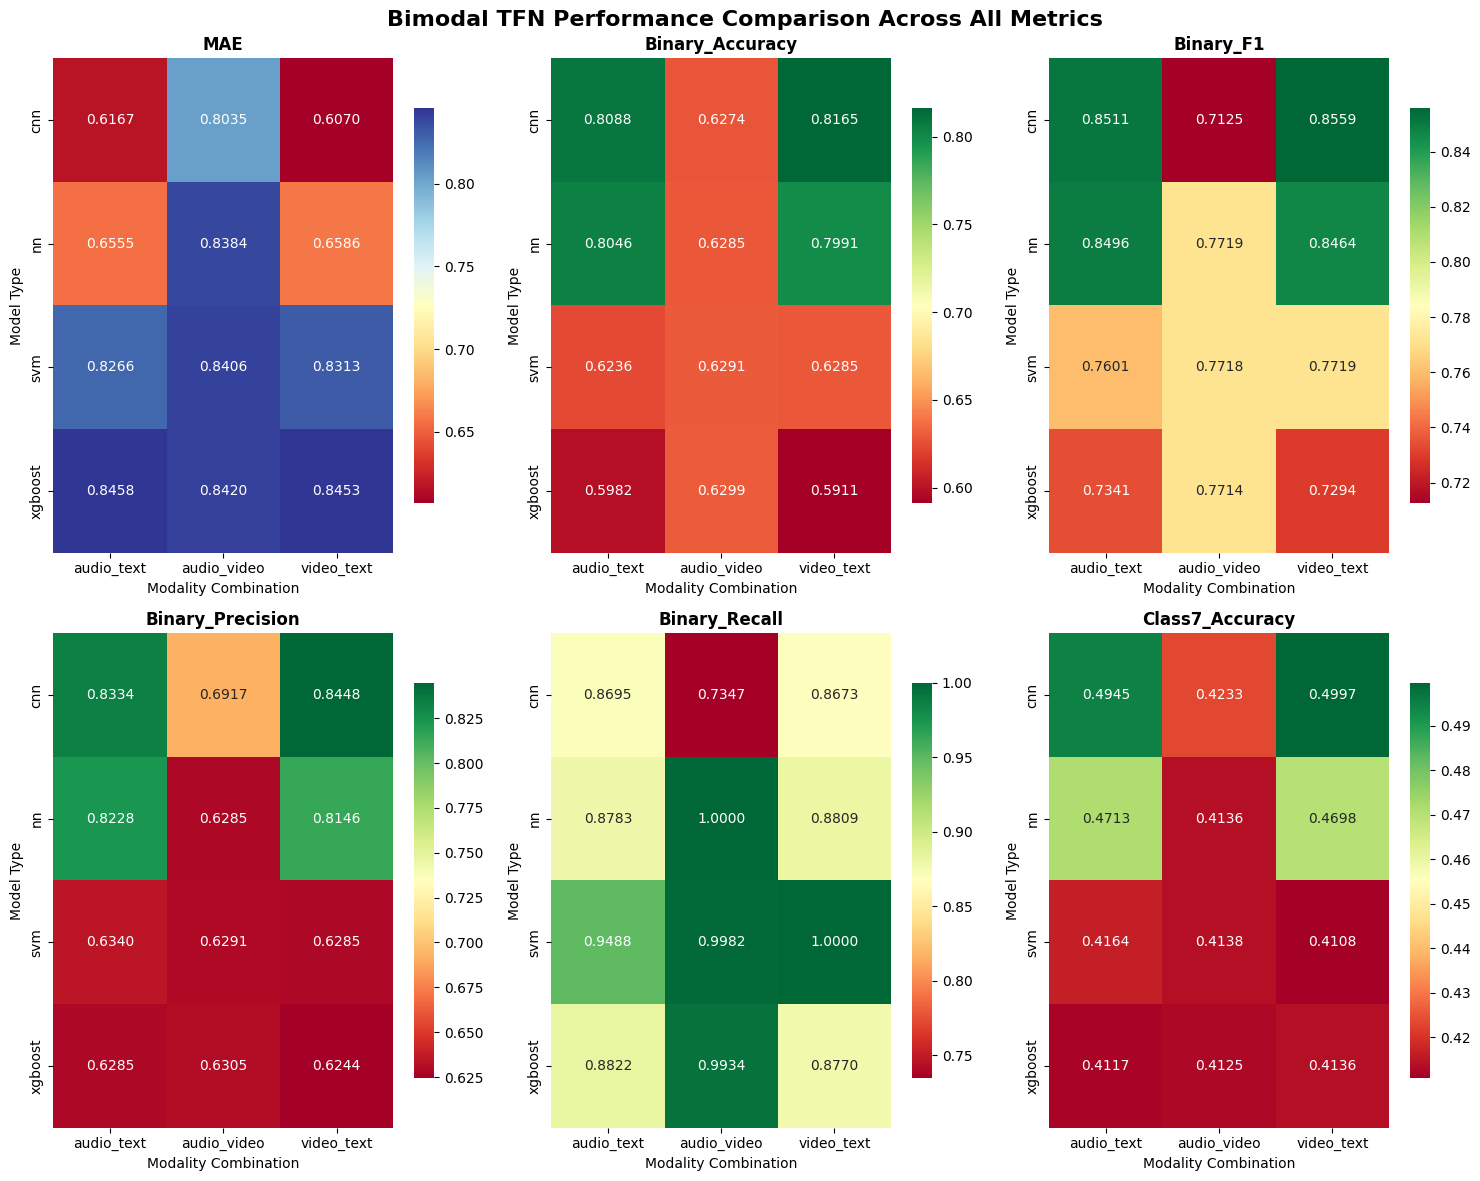

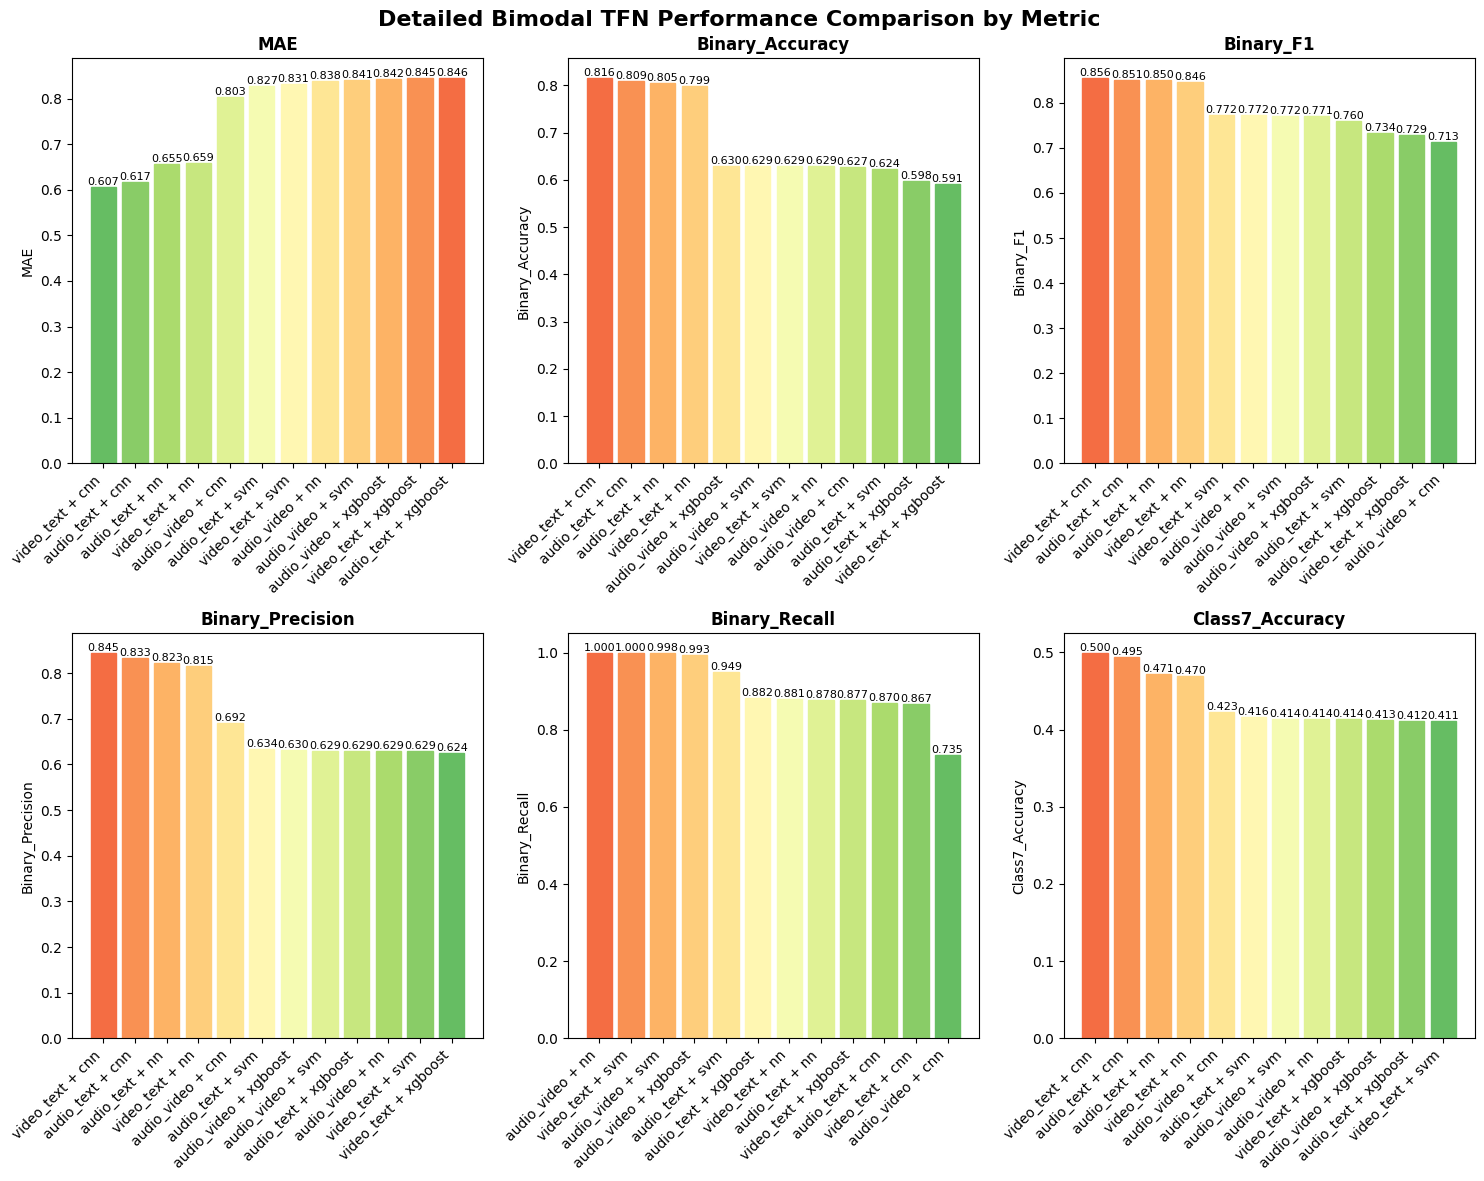

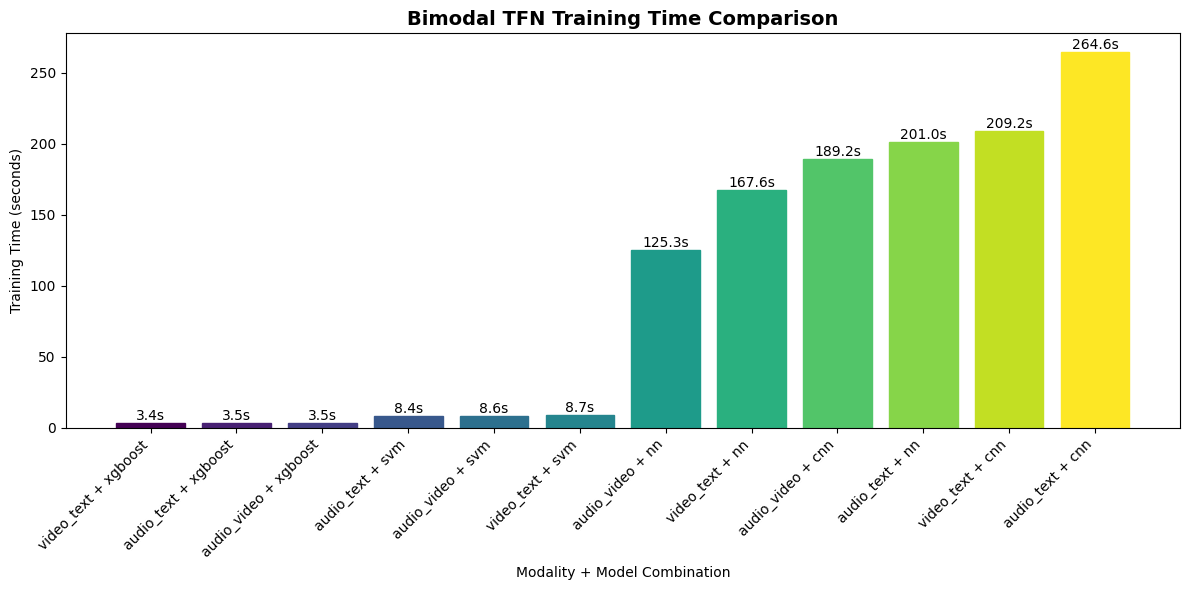

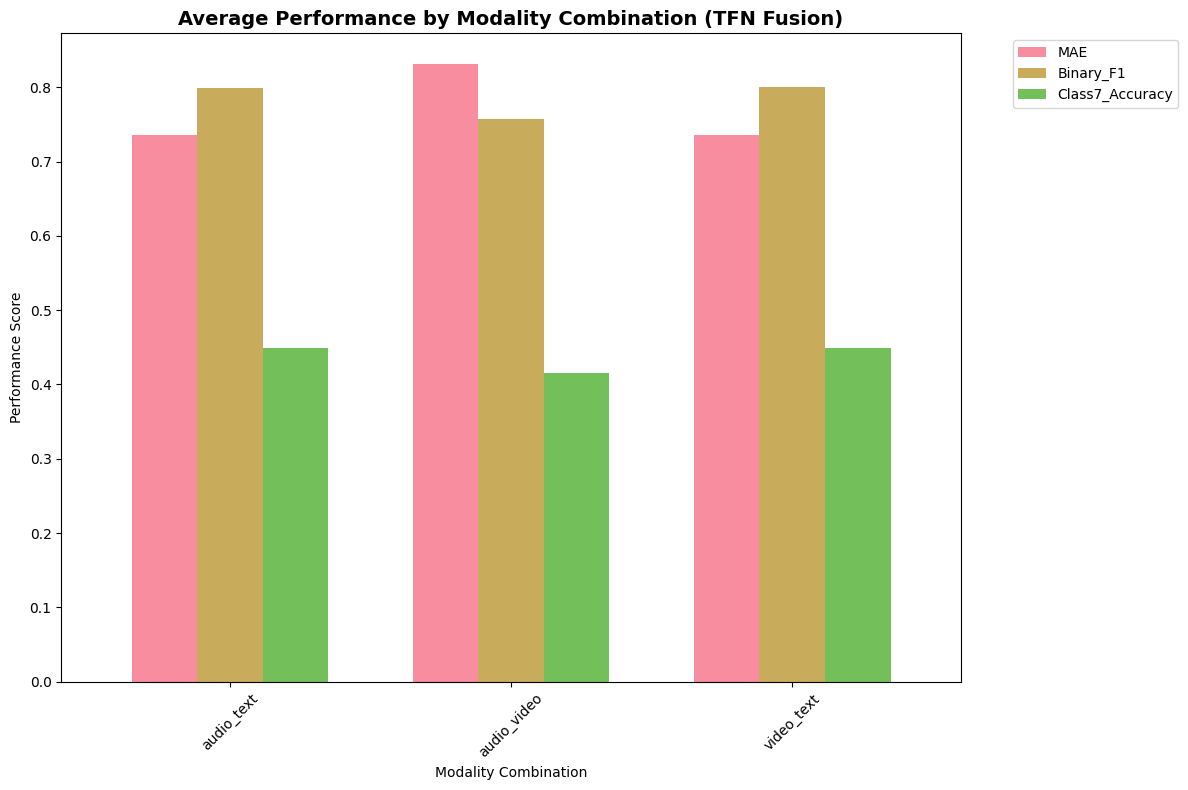

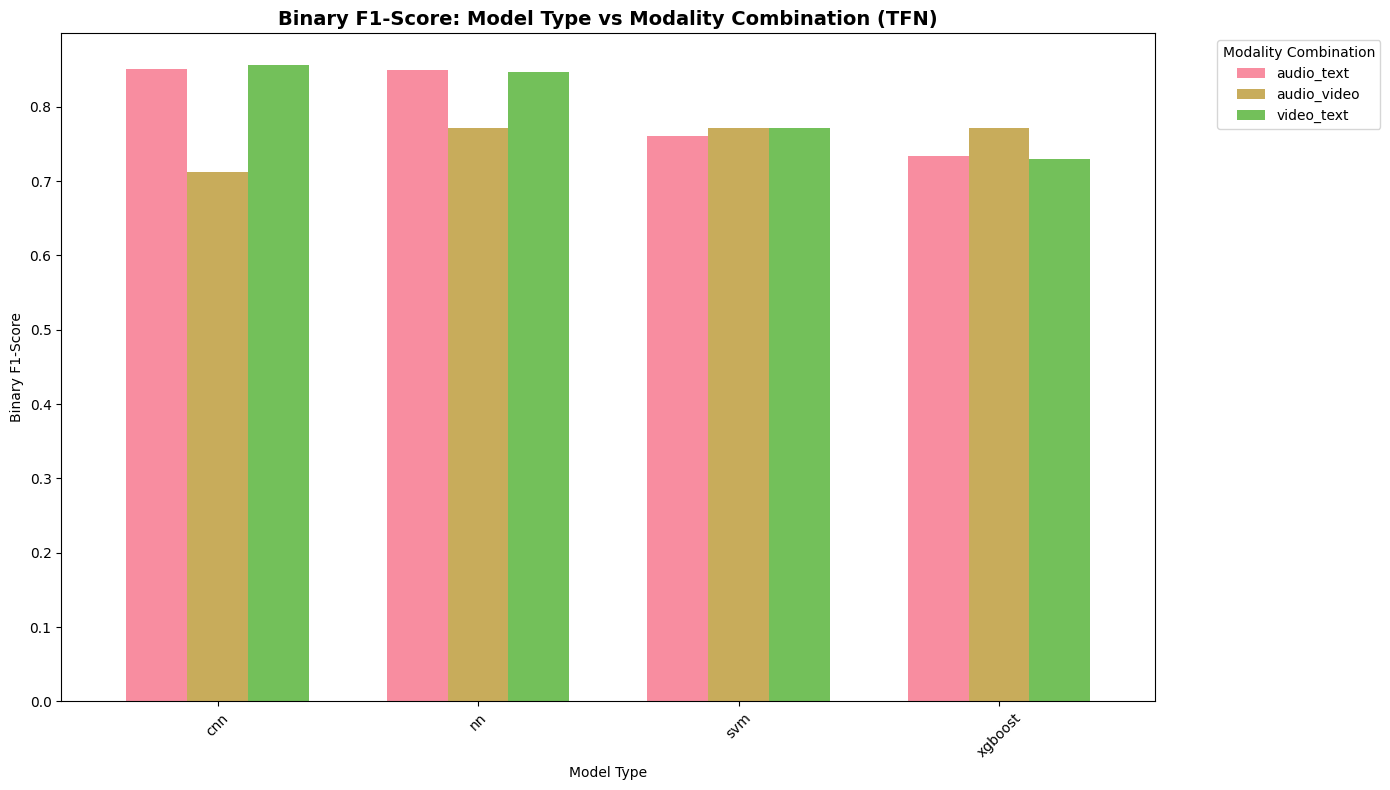


SUMMARY STATISTICS

Best Performance by Metric:
MAE: video_text + cnn (0.6070)
Binary_Accuracy: video_text + cnn (0.8165)
Binary_F1: video_text + cnn (0.8559)
Binary_Precision: video_text + cnn (0.8448)
Binary_Recall: audio_video + nn (1.0000)
Class7_Accuracy: video_text + cnn (0.4997)

Overall Ranking (weighted by multiple metrics):

Top 5 Bimodal TFN Combinations:
1. video_text + cnn (Score: 0.950)
2. audio_text + cnn (Score: 0.914)
3. audio_text + nn (Score: 0.832)
4. video_text + nn (Score: 0.814)
5. video_text + svm (Score: 0.236)

All results saved to 'bimodal_tfn_comparison_results.csv'
Visualization files created:
- bimodal_tfn_performance_heatmaps.png
- bimodal_tfn_performance_bars.png
- bimodal_tfn_training_time_comparison.png
- bimodal_tfn_modality_performance.png
- bimodal_tfn_model_modality_comparison.png

Bimodal TFN evaluation complete!

COMPREHENSIVE BIMODAL TFN ANALYSIS SUMMARY

🔄 MODALITY COMBINATION ANALYSIS:
--------------------------------------------------
      

In [36]:
print("\n" + "="*80)
print("GENERATING COMPREHENSIVE TFN ANALYSIS AND VISUALIZATIONS")
print("="*80)


# ==========================================================================================
# COMPREHENSIVE RESULTS ANALYSIS AND VISUALIZATION
# ==========================================================================================

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 12)

# 1. Heatmap of all metrics
fig, axes = plt.subplots(2, 3, figsize=fig_size)
fig.suptitle('Bimodal TFN Performance Comparison Across All Metrics', fontsize=16, fontweight='bold')

metrics_to_plot = ['MAE', 'Binary_Accuracy', 'Binary_F1', 'Binary_Precision', 'Binary_Recall', 'Class7_Accuracy']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Create pivot table for heatmap
    pivot_data = results_df.pivot(index='Model_Type', columns='Modality_Combination', values=metric)
    
    # For MAE, lower is better, so use reverse colormap
    cmap = 'RdYlBu' if metric == 'MAE' else 'RdYlGn'
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap=cmap, ax=ax, 
                cbar_kws={'shrink': 0.8})
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_xlabel('Modality Combination')
    ax.set_ylabel('Model Type')

plt.tight_layout()
plt.savefig('bimodal_tfn_performance_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Bar plots for each metric
fig, axes = plt.subplots(2, 3, figsize=fig_size)
fig.suptitle('Detailed Bimodal TFN Performance Comparison by Metric', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Create combination labels
    results_df['Combination'] = results_df['Modality_Combination'] + ' + ' + results_df['Model_Type']
    
    # Sort by performance (ascending for MAE, descending for others)
    sorted_df = results_df.sort_values(metric, ascending=(metric == 'MAE'))
    
    bars = ax.bar(range(len(sorted_df)), sorted_df[metric])
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(sorted_df)))
    ax.set_xticklabels(sorted_df['Combination'], rotation=45, ha='right')
    
    # Color bars based on performance
    if metric == 'MAE':
        # For MAE, lower is better - color from green (best) to red (worst)
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(bars)))
    else:
        # For other metrics, higher is better - color from red (worst) to green (best)
        colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(bars)))
    
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('bimodal_tfn_performance_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Training time comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
results_df['Combination'] = results_df['Modality_Combination'] + ' + ' + results_df['Model_Type']
sorted_time_df = results_df.sort_values('Training_Time')

bars = ax.bar(range(len(sorted_time_df)), sorted_time_df['Training_Time'])
ax.set_title('Bimodal TFN Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Training Time (seconds)')
ax.set_xlabel('Modality + Model Combination')
ax.set_xticks(range(len(sorted_time_df)))
ax.set_xticklabels(sorted_time_df['Combination'], rotation=45, ha='right')

# Color bars based on training time
colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('bimodal_tfn_training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Additional bimodal-specific visualization: Modality comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
modality_performance = results_df.groupby('Modality_Combination')[['MAE', 'Binary_F1', 'Class7_Accuracy']].mean()
modality_performance.plot(kind='bar', ax=ax, alpha=0.8, width=0.7)
ax.set_title('Average Performance by Modality Combination (TFN Fusion)', fontsize=14, fontweight='bold')
ax.set_ylabel('Performance Score')
ax.set_xlabel('Modality Combination')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('bimodal_tfn_modality_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Model type comparison across modalities
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
model_modality_pivot = results_df.pivot_table(index='Model_Type', columns='Modality_Combination', values='Binary_F1', aggfunc='mean')
model_modality_pivot.plot(kind='bar', ax=ax, alpha=0.8, width=0.7)
ax.set_title('Binary F1-Score: Model Type vs Modality Combination (TFN)', fontsize=14, fontweight='bold')
ax.set_ylabel('Binary F1-Score')
ax.set_xlabel('Model Type')
ax.legend(title='Modality Combination', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('bimodal_tfn_model_modality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Summary statistics table
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Best performance for each metric
print("\nBest Performance by Metric:")
for metric in metrics_to_plot:
    if metric == 'MAE':
        best_idx = results_df[metric].idxmin()
        print(f"{metric}: {results_df.loc[best_idx, 'Modality_Combination']} + {results_df.loc[best_idx, 'Model_Type']} "
              f"({results_df.loc[best_idx, metric]:.4f})")
    else:
        best_idx = results_df[metric].idxmax()
        print(f"{metric}: {results_df.loc[best_idx, 'Modality_Combination']} + {results_df.loc[best_idx, 'Model_Type']} "
              f"({results_df.loc[best_idx, metric]:.4f})")

# Overall ranking (you can customize the weighting)
print("\nOverall Ranking (weighted by multiple metrics):")
# Normalize metrics (0-1 scale) and compute weighted score
normalized_df = results_df.copy()
for metric in metrics_to_plot:
    if metric == 'MAE':
        # For MAE, lower is better, so invert
        normalized_df[f'{metric}_norm'] = 1 - (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())
    else:
        # For others, higher is better
        normalized_df[f'{metric}_norm'] = (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())

# Compute weighted score (you can adjust weights)
weights = {'MAE': 0.3, 'Binary_Accuracy': 0.2, 'Binary_F1': 0.2, 'Binary_Precision': 0.1, 'Binary_Recall': 0.1, 'Class7_Accuracy': 0.1}
normalized_df['Overall_Score'] = sum(normalized_df[f'{metric}_norm'] * weights[metric] for metric in weights.keys())

# Sort by overall score
ranked_df = normalized_df.sort_values('Overall_Score', ascending=False)
print("\nTop 5 Bimodal TFN Combinations:")
for i in range(min(5, len(ranked_df))):
    row = ranked_df.iloc[i]
    print(f"{i+1}. {row['Modality_Combination']} + {row['Model_Type']} (Score: {row['Overall_Score']:.3f})")

print(f"\nAll results saved to 'bimodal_tfn_comparison_results.csv'")
print("Visualization files created:")
print("- bimodal_tfn_performance_heatmaps.png")
print("- bimodal_tfn_performance_bars.png") 
print("- bimodal_tfn_training_time_comparison.png")
print("- bimodal_tfn_modality_performance.png")
print("- bimodal_tfn_model_modality_comparison.png")
print("\nBimodal TFN evaluation complete!")

# ==========================================================================================
# DETAILED STATISTICAL ANALYSIS AND SUMMARY  
# ==========================================================================================

print("\n" + "="*80)
print("COMPREHENSIVE BIMODAL TFN ANALYSIS SUMMARY")
print("="*80)

# Store best performers for later use
best_performers = {}
for metric in metrics_to_plot:
    if metric == 'MAE':
        best_idx = results_df[metric].idxmin()
    else:
        best_idx = results_df[metric].idxmax()
    best_performers[metric] = f"{results_df.loc[best_idx, 'Modality_Combination']} + {results_df.loc[best_idx, 'Model_Type']}"

# Modality combination analysis
print(f"\n🔄 MODALITY COMBINATION ANALYSIS:")
print("-" * 50)
modality_avg = results_df.groupby('Modality_Combination')[['MAE', 'Binary_F1', 'Class7_Accuracy']].mean().round(4)
print(modality_avg)

# Model type analysis
print(f"\n🏗️ MODEL TYPE ANALYSIS:")
print("-" * 50)
model_avg = results_df.groupby('Model_Type')[['MAE', 'Binary_F1', 'Class7_Accuracy']].mean().round(4)
print(model_avg)

# Neural vs Classical comparison
print(f"\n🧠 NEURAL vs CLASSICAL MODELS:")
print("-" * 50)
neural_models = results_df[results_df['Model_Type'].isin(['nn', 'cnn'])]

In [37]:
results_df

,Modality_Combination,Model_Type,MAE,Binary_Accuracy,Binary_F1,Binary_Precision,Binary_Recall,Class7_Accuracy,Training_Time,Combination
0,audio_video,nn,0.838416,0.628509,0.771882,0.628509,1.000000,0.413608,125.334941,audio_video + nn
1,audio_video,cnn,0.803453,0.627408,0.712527,0.691674,0.734676,0.423267,189.235492,audio_video + cnn
2,audio_video,svm,0.840635,0.629059,0.771835,0.629139,0.998249,0.413823,8.627165,audio_video + svm
3,audio_video,xgboost,0.841982,0.629884,0.771375,0.630453,0.993433,0.412535,3.543161,audio_video + xgboost
4,audio_text,nn,0.655486,0.804623,0.849640,0.822806,0.878284,0.471346,201.041164,audio_text + nn
5,audio_text,cnn,0.616693,0.808751,0.851082,0.833403,0.869527,0.494527,264.583398,audio_text + cnn
6,audio_text,svm,0.826626,0.623555,0.760084,0.633996,0.948774,0.416398,8.416003,audio_text + svm
7,audio_text,xgboost,0.845782,0.598239,0.734062,0.628509,0.882224,0.411676,3.458001,audio_text + xgboost
8,video_text,nn,0.658553,0.799119,0.846445,0.814575,0.880911,0.469843,167.633523,video_text + nn
9,video_text,cnn,0.606971,0.816456,0.855908,0.844776,0.867338,0.499678,209.209942,video_text + cnn
